# Problema de negócio

**Análise de vendas de filiais de lojas de supermercado**

Analisando as vendas das lojas e sua dependência da área das lojas e da contagem diária de clientes

**Contexto**

Um supermercado é uma loja de autoatendimento que oferece uma grande variedade de alimentos, bebidas e produtos domésticos, organizados em seções. Esse tipo de loja é maior e tem uma seleção mais ampla do que as mercearias anteriores, mas é menor e mais limitada na variedade de mercadorias do que um hipermercado ou um grande mercado. No uso diário dos EUA, no entanto, "mercearia" é sinônimo de supermercado e não é usado para se referir a outros tipos de lojas que vendem mantimentos.

[https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount)

**Como o problema é resolvido atualmente ?**

    Os analistas de negócio usam a média das últimas vendas para estimar as próximas nas lojas em destaque.

    Baseline = média das últimas vendas:
        - RMSE: 17993.77
        - MAPE: 27.68%

# Bibliotecas

In [1]:
import psycopg2
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances


import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import pickle
from dotenv import load_dotenv

In [2]:
# Variáveis de ambiente
dotenv_path = r"C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\.env\.env"
load_dotenv(dotenv_path)

True

# Extração Supermarket_Gold do banco de dados Supermarket

In [99]:
# Conectar ao banco de dados
conn = psycopg2.connect(
    host="localhost",
    database="Supermarket",
    user="postgres",
    password=os.environ.get('PG_PASSWORD')
)

In [100]:
# Consultar o banco de dados e criar o DataFrame pandas
df = pd.read_sql_query("SELECT * FROM Supermarket_Gold;", conn)

In [5]:
# Fechar a conexão com o banco de dados
conn.close()

In [6]:
df.head()

store_id  store_area  items_available  daily_customer_count  store_sales
0         1        1659             1961                   530        66490
1         2        1461             1752                   210        39820
2         3        1340             1609                   720        54010
3         4        1451             1748                   620        53730
4         5        1770             2111                   450        46620

# Entendimento dos dados

No conjunto de dados, você obterá dados de diferentes lojas de uma empresa de supermercado de acordo com seus IDs de loja que, para facilitar, foram convertidos em números inteiros positivos.

**ID da loja:** (Índice) ID da loja específica.

**Store_Area:** Área Física da loja em metro quadrado.

**Items_Available:** Número de diferentes itens disponíveis na loja correspondente.

**Daily_Customer_Count:** número de clientes que visitaram as lojas em média ao longo do mês.

**Store_Sales:** Vendas em (US$) que as lojas realizaram.

# Divisão de treino e teste

In [7]:
# Se os Store ID são recorrentes em ordem crescente os últimos registros são como se fossem as últimas vendas

df.shape

(896, 5)

In [8]:
# 20% do dataframe dá quantas linhas ?
0.20 * df.shape[0]

179.20000000000002

In [9]:
#train, test = train_test_split(df, test_size=0.20, random_state=42)
test = df.tail(180)
train = df[:-180]

In [10]:
train.shape

(716, 5)

In [11]:
test.shape

(180, 5)

In [12]:
# dados para ajustar modelo e tunar hiperparâmetros
train

store_id  store_area  items_available  daily_customer_count  store_sales
0           1        1659             1961                   530        66490
1           2        1461             1752                   210        39820
2           3        1340             1609                   720        54010
3           4        1451             1748                   620        53730
4           5        1770             2111                   450        46620
..        ...         ...              ...                   ...          ...
711       712        1360             1612                   490        61080
712       713        1542             1844                   680        51380
713       714        1631             1947                   670        84410
714       715        1246             1482                  1070        60680
715       716        1990             2384                  1110        64690

[716 rows x 5 columns]

In [13]:
# dados para simular produção
test

store_id  store_area  items_available  daily_customer_count  store_sales
716       717         967             1154                   560        45780
717       718        1582             1894                  1100        41800
718       719        1430             1743                   970        53230
719       720        1827             2160                   930        36160
720       721        1118             1338                  1040        40450
..        ...         ...              ...                   ...          ...
891       892        1582             1910                  1080        66390
892       893        1387             1663                   850        82080
893       894        1200             1436                  1060        76440
894       895        1299             1560                   770        96610
895       896        1174             1429                  1110        54340

[180 rows x 5 columns]

# EDA 
 - Na amostra de treino apenas
 - O teste não será visto pois é para simular o ambiente em produção

In [14]:
df_train = train.copy()

In [15]:
df_train.head()

store_id  store_area  items_available  daily_customer_count  store_sales
0         1        1659             1961                   530        66490
1         2        1461             1752                   210        39820
2         3        1340             1609                   720        54010
3         4        1451             1748                   620        53730
4         5        1770             2111                   450        46620

In [16]:
# Sanit check

def sanit_check(df:pd.DataFrame):

    print(f'Número de linhas: {df.shape[0]} \n')
    print(f'Número de colunas {df.shape[1]} \n')
    print(f'Número de linhas duplicadas: {df.duplicated().sum()}\n')
    print(f'Número de linhas nulas:\n {df.isnull().sum()}')

    return None

In [17]:
sanit_check(df_train)

Número de linhas: 716 

Número de colunas 5 

Número de linhas duplicadas: 0

Número de linhas nulas:
 store_id                0
store_area              0
items_available         0
daily_customer_count    0
store_sales             0
dtype: int64


Não há dados duplicados ou nulos !

<Axes: >

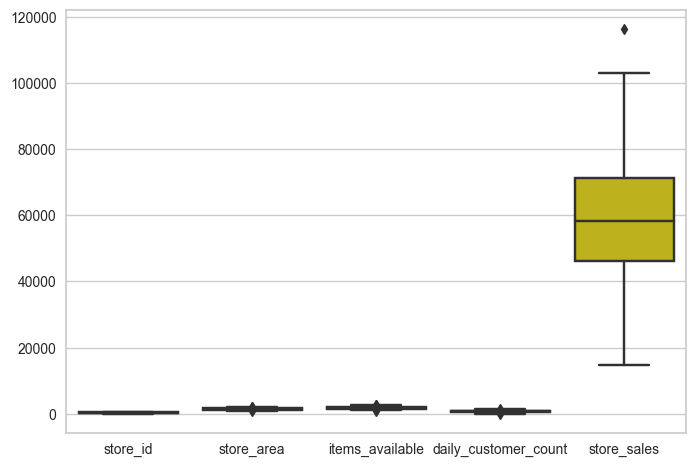

In [18]:
# Check outliers
sns.boxplot(df_train)

Aparentemente temos um outlier nas vendas.

In [19]:
df_train.describe()

store_id   store_area  items_available  daily_customer_count  \
count  716.000000   716.000000       716.000000            716.000000   
mean   358.500000  1490.656425      1787.889665            784.930168   
std    206.835684   249.757655       299.624992            268.236136   
min      1.000000   775.000000       932.000000             10.000000   
25%    179.750000  1317.750000      1578.250000            600.000000   
50%    358.500000  1486.000000      1777.000000            770.000000   
75%    537.250000  1659.250000      1994.500000            970.000000   
max    716.000000  2229.000000      2667.000000           1530.000000   

         store_sales  
count     716.000000  
mean    58961.005587  
std     16988.219698  
min     14920.000000  
25%     46087.500000  
50%     58385.000000  
75%     71150.000000  
max    116320.000000

Achados da descritiva acima:

    - Store_Area, Items_Available,	Daily_Customer_Count têm um leve desvio padrão considerando a distância entre os valores máximos e minimos destas variáveis
    - Store_Sales tem um desvio padrão maior, acredito que esta target não tenha uma distribuição normal deve-se testar esta hipótese mais tarde
    - A venda máxima diária foi de $ 116320 e a minima de $ 14920

# Hipóteses de negócio

### 1 - Quanto maior a área física da loja maior as vendas !

<Axes: xlabel='store_area', ylabel='store_sales'>

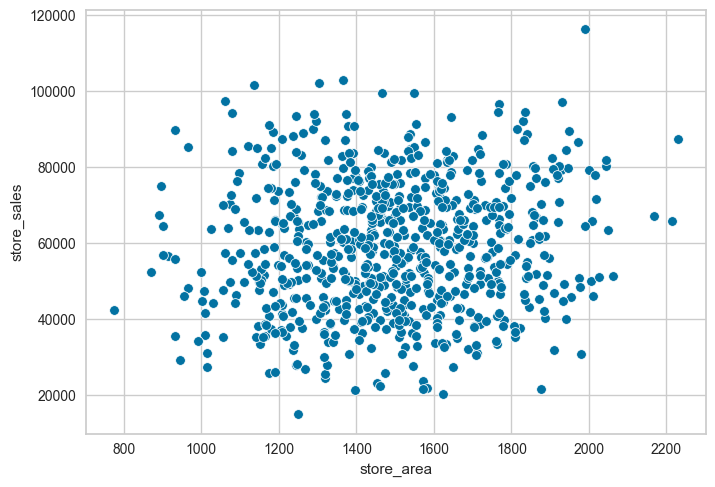

In [20]:
sns.scatterplot(x=df_train['store_area'], y=df_train['store_sales'])

- Analisando o gráfico aparenta ser falsa esta hipótese, não vejo uma relação linear forte entre os dados

- As maiores vendas se concetram em lojas com 1200 a 1800 metros quadrados

In [21]:
# Testar a H0 de que há uma correlação linear entre a área física da loja e as vendas. 
from scipy.stats import pearsonr

In [22]:
corr, p_value = pearsonr(df_train['store_area'], df_train['store_sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10059845295634516
Valor p: 0.0070607636788003695


O valor p correspondente testa a hipótese nula de que não há correlação linear entre as duas variáveis. Se o valor p for menor que um nível de significância pré-definido (por exemplo, 0,05), isso indica que a hipótese nula pode ser rejeitada em favor da hipótese alternativa de que há uma correlação linear significativa entre as duas variáveis. O valor da correlação indica a direção e a magnitude da relação, ou seja, quanto maior a área física da loja, maior as vendas, mantidas as outras variáveis constantes.

H0 aceita ! Lembrando que correlação não é causalidade

### 2 - Quanto mais itens disponíveis na loja maior as vendas !

<Axes: xlabel='items_available', ylabel='store_sales'>

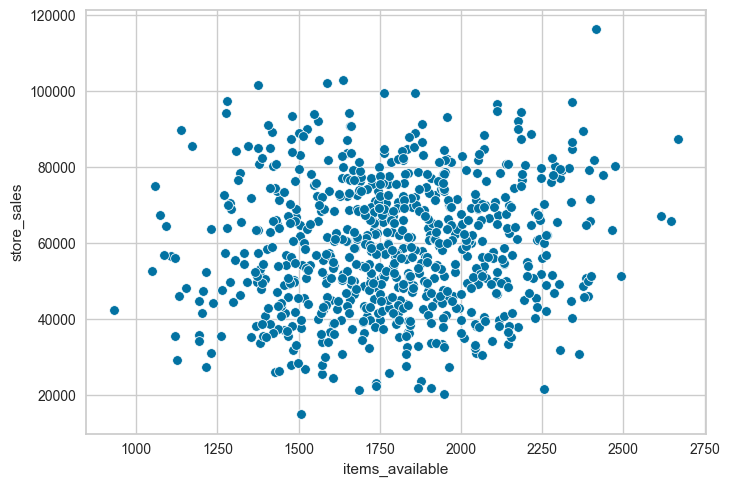

In [23]:
sns.scatterplot(x=df_train['items_available'], y=df_train['store_sales'])

- Os dados estão bastante dispersos também não há uma forte correlação entre a quantidade de itens para avaliação e o valor de vendas
- Os maiores valores de vendas se concetram na quantidade de itens para avaliação entre 1250 e 2250.

In [24]:
corr, p_value = pearsonr(df_train['items_available'], df_train['store_sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10248872832206991
Valor p: 0.006053840059244279


H0 aceita ! Hipótese verdadeira.

### 3 - Quanto mais visitas na loja maior as vendas !

<Axes: xlabel='daily_customer_count', ylabel='store_sales'>

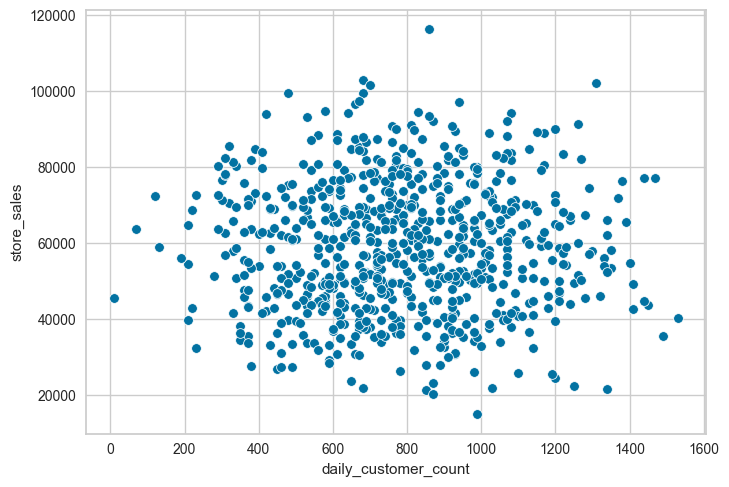

In [25]:
sns.scatterplot(x=df_train['daily_customer_count'], y=df_train['store_sales'])

- Pelo gráfico tambem não temos uma forte correlação entre as variáveis
- Os maiores valores de vendas se concetram entre 600 e 1000 visitantes nas lojas

In [26]:
corr, p_value = pearsonr(df_train['daily_customer_count'], df_train['store_sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.0013418808444295072
Valor p: 0.9714070959944522


H0 rejeitada ! Há uma correlação bastante fraca entre as variáveis, quanto maior o número de visitantes menor é o valor de vendas.

    - Deve-se investigar o porquê e a causa, pois há um viés em pensarmos que quanto mais visitantes maiores as chances de compra, porém não é isto que oconteceu.
    - Será que quanto maior o número de visitantes pior é o atendimento ? Ou os clientes não gostam de esperar demais nas filas ? Deve-se investigar no campo !

# Análise Multivariada

In [27]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()

corr.style.background_gradient(cmap= 'coolwarm')

# Análise bivariada

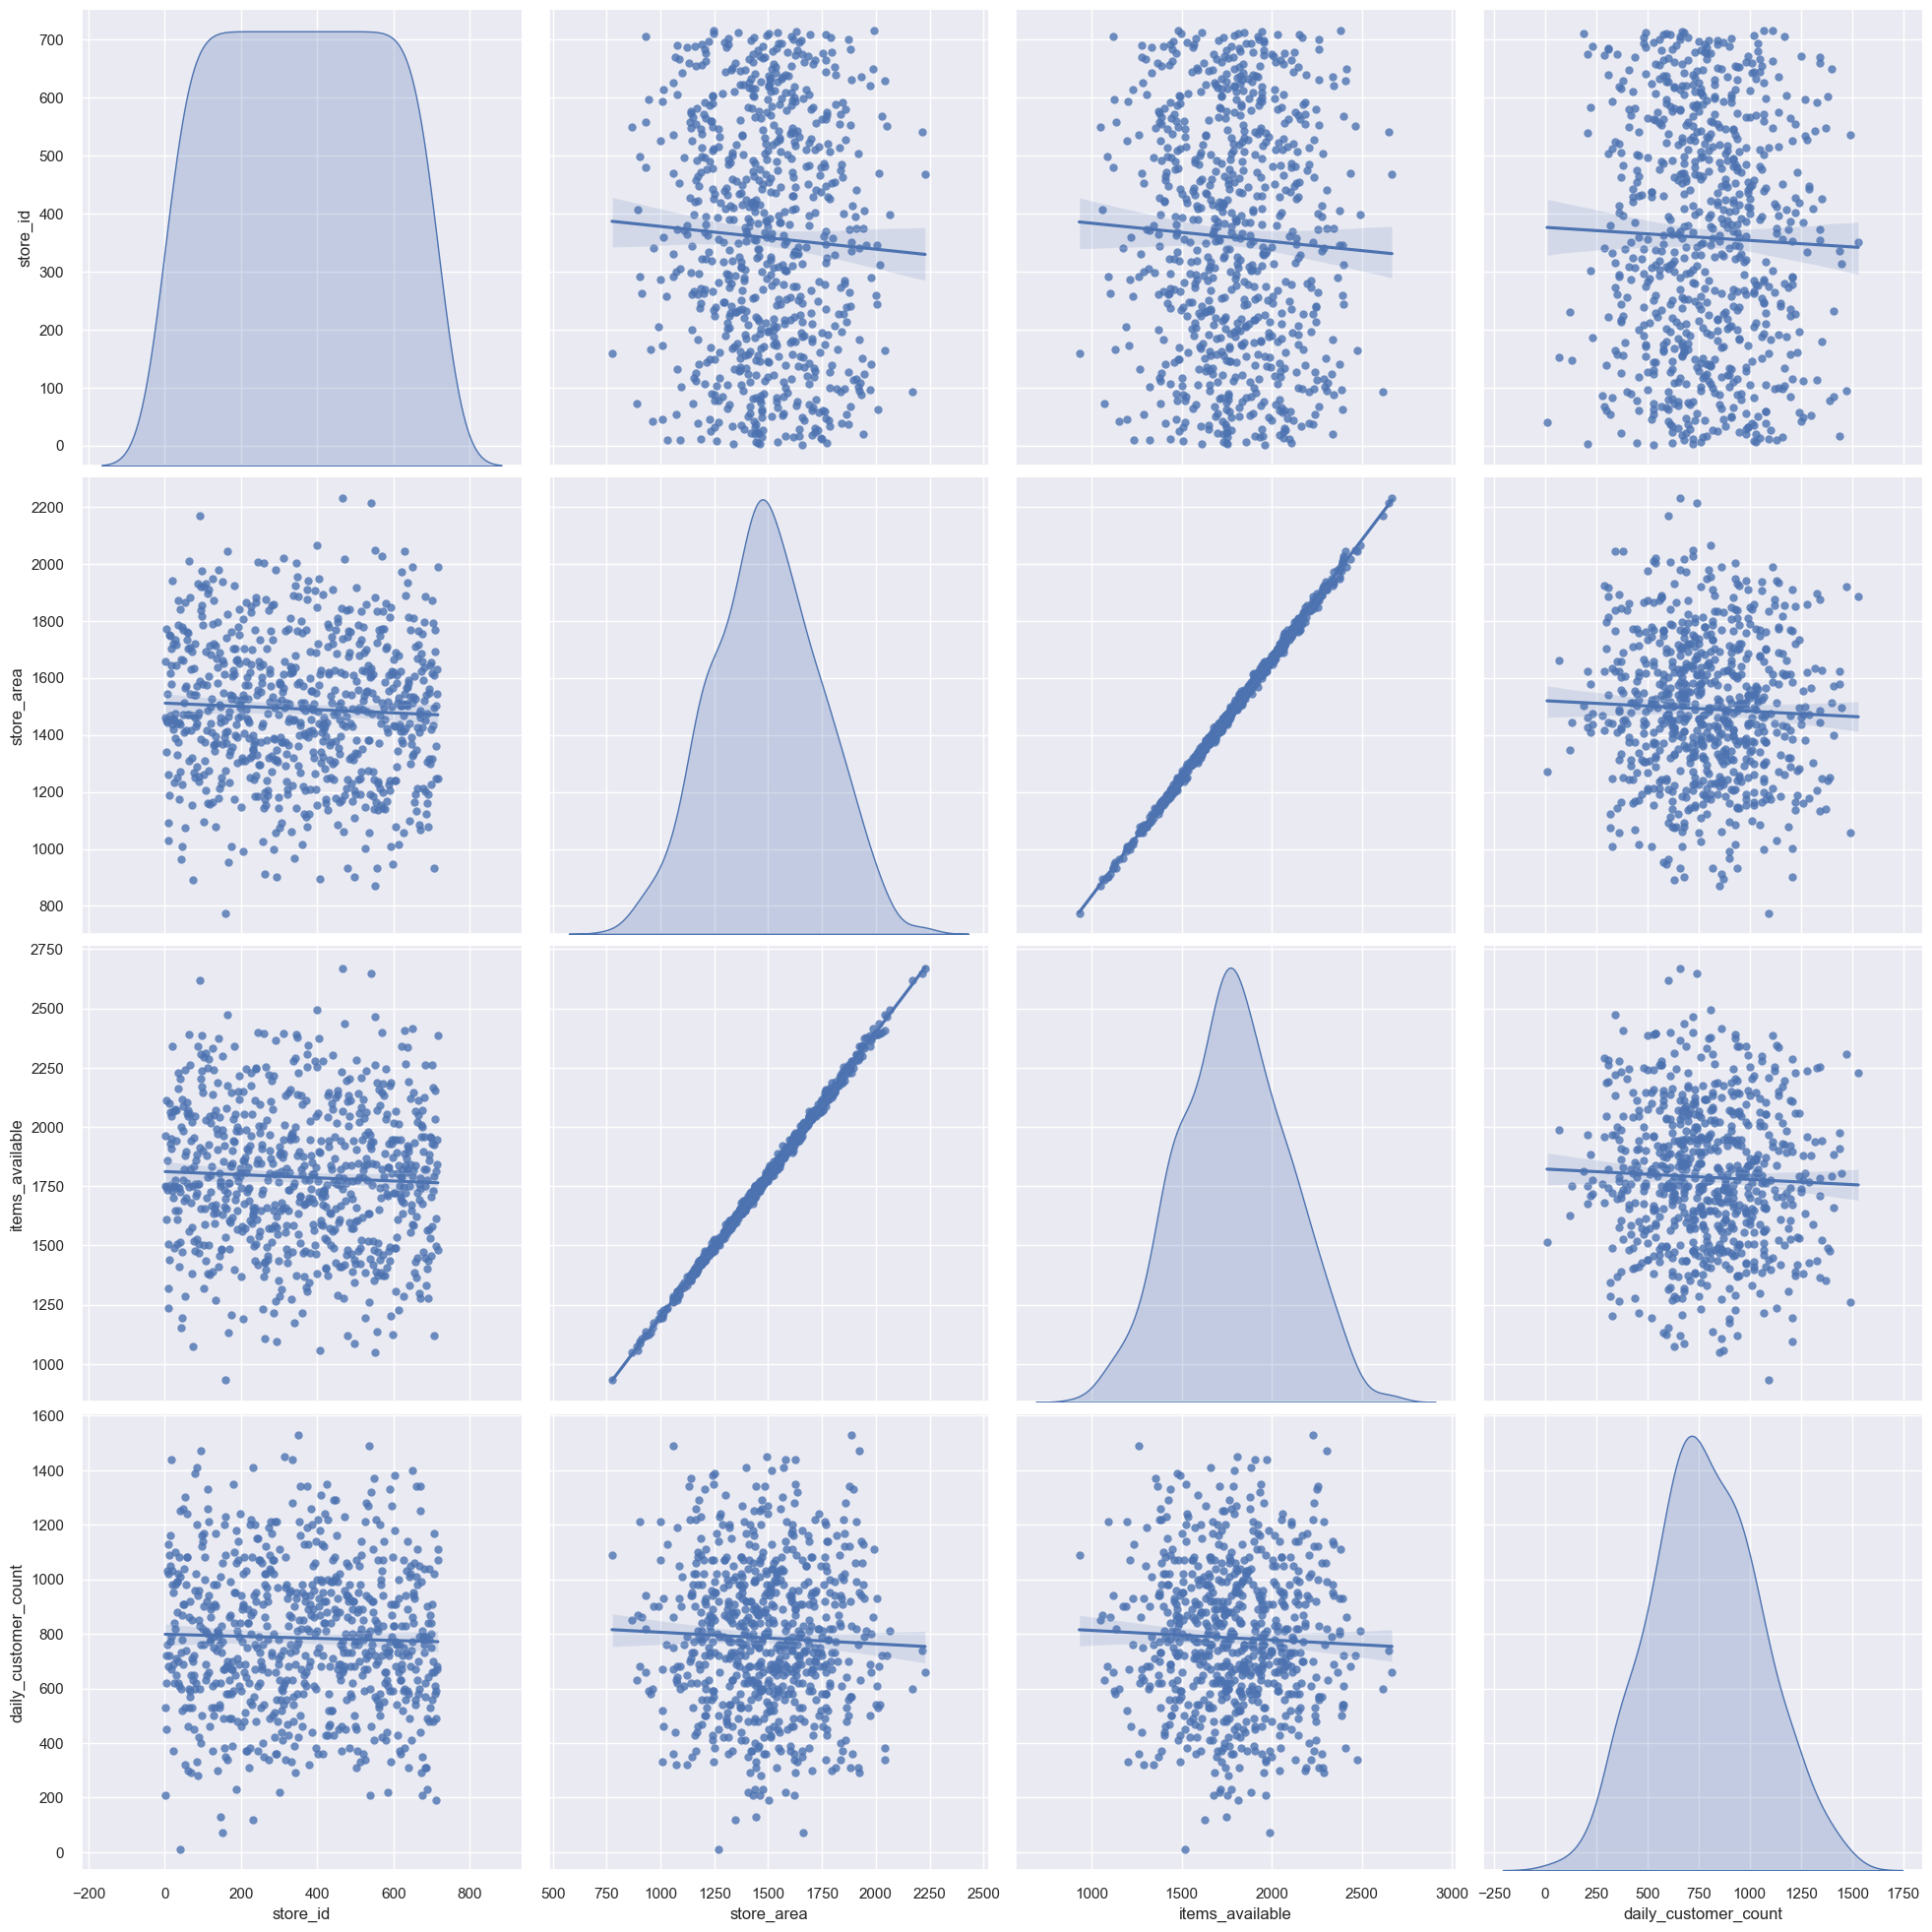

In [28]:
sns.set()
sns.pairplot(df_train.iloc[:,[0,1,2,3]],height = 5 ,kind ='reg',diag_kind='kde')
plt.show()

- A uma forte correlação entre Store_Area e Items_Available
- A correlações positivas fracas entre as variáveis Store_Area e Items_Available com a target Store_Sales

Dito isto será um desafio montar um modelo linear que consiga bons resultados com estas variáveis.

# Análise Univariada

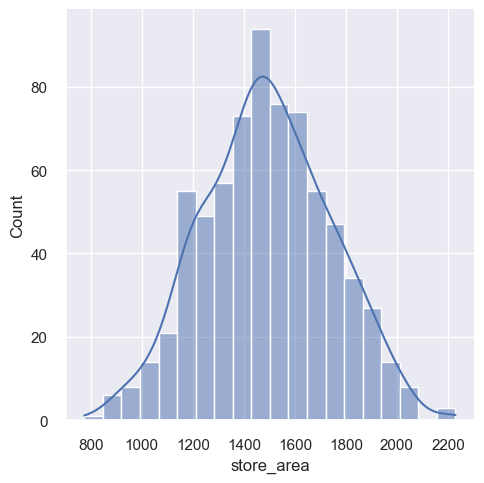

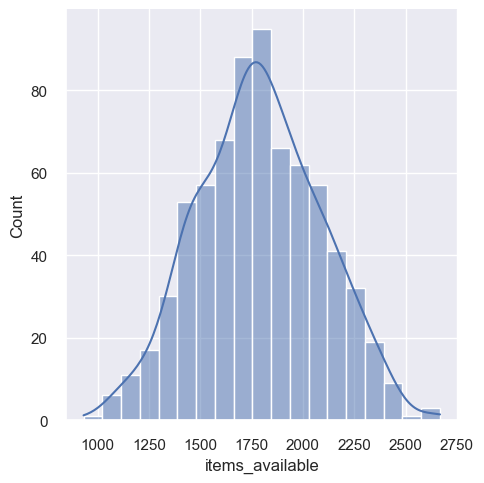

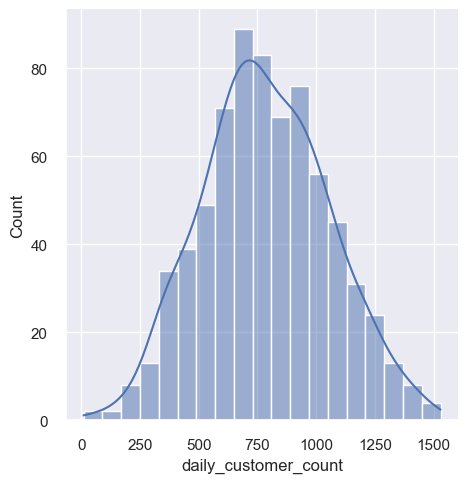

In [29]:
for col in df_train.iloc[:,[1,2,3]].columns.to_list():

    sns.displot(df_train[col], kde=True)

- Os gráficos apresentam as variáveis com as distribuições de dados em formato de sino, mas não tenho certeza se elas têm uma distribuição normal, para validar a premissa dos modelos lineares.
- Vou fazer alguns testes de hipóteses nestas variáveis para ter certeza !

In [30]:
from scipy import stats

In [31]:
def test_norm(data: pd.DataFrame):
    for col in data.columns:
        stat, p = stats.shapiro(data[col])
        print(f'Coluna {col}: Estatística de teste = {stat:.3f}, p-valor = {p:.3f}')

        if p > 0.05:
            print(f'Os dados da coluna {col} têm distribuição normal.')
        else:
            print(f'Os dados da coluna {col} não têm distribuição normal.')

In [32]:
test_norm(df_train.iloc[:,[1,2,3]])

Coluna store_area: Estatística de teste = 0.997, p-valor = 0.339
Os dados da coluna store_area têm distribuição normal.
Coluna items_available: Estatística de teste = 0.997, p-valor = 0.284
Os dados da coluna items_available têm distribuição normal.
Coluna daily_customer_count: Estatística de teste = 0.997, p-valor = 0.165
Os dados da coluna daily_customer_count têm distribuição normal.


Por não termos uma distribuiçõ normal na target talvez precisaremos alterar sua natureza para facilitar a previsão dos algoritmos ou usar modelos robustos para estes tipos de dados 

# Baseline de média dos analistas nos dados de teste

In [33]:
# teste
df_teste = test.copy()

In [34]:
df_teste.head()

store_id  store_area  items_available  daily_customer_count  store_sales
716       717         967             1154                   560        45780
717       718        1582             1894                  1100        41800
718       719        1430             1743                   970        53230
719       720        1827             2160                   930        36160
720       721        1118             1338                  1040        40450

In [35]:
# Modelo  de média

# Calcular média de vendas no conjunto de treino para simular a previsão com esta média no conjunto de teste
mean_sales = np.mean(df_train['store_sales'])
# Prever a média de vendas para cada loja
predictions = np.full(len(df_teste), mean_sales)

In [36]:
# Calcular erro baseline RMSE MAPE
RMSE_baseline = np.sqrt(mean_squared_error(df_teste['store_sales'], predictions))
MAPE_baseline = mean_absolute_percentage_error(df_teste['store_sales'], predictions)

print(f"RMSE: {RMSE_baseline:.2f}")
print(f"MAPE: {MAPE_baseline:.2%}")

RMSE: 17993.77
MAPE: 27.68%


    - O modelo de média tem um erro em torno de 27,68% 
    - Nosso objetivo será reduzir este erro

# Modelagem / Machine Learning

## Feature Engineering

- Premissa 1º é não criar features derivadas das vendas para não vazar informação e sabendo que não terei informações sobre vendas quando o modelo estiver em produção

    - **Densidade de itens disponíveis:** esta feature indica quantos itens estão disponíveis por metro quadrado de espaço da loja. Isso pode ajudar a entender se a loja está utilizando efetivamente seu espaço de varejo. Para criar essa feature, podemos dividir o número de itens disponíveis pela área da loja.
    
    - **Frequência média diária de visitas:** esta feature indica com que frequência os clientes visitam a loja. Para criá-la, podemos dividir o número de visitas pelo número total de clientes e por 30 dias.
    
    - **Taxa de ocupação da loja:** esta feature indica o quão lotada a loja está em relação ao seu espaço físico. Para criá-la, podemos dividir o número médio diário de clientes pela área da loja.

In [37]:
def feature_engineering(df:pd.DataFrame) -> pd.DataFrame:
    
    # Densidade de itens disponíveis
    df['density_of_available_items'] = df['items_available'] / df['store_area']
    
    # Frequência média diária de visitas
    df['average_frequency_of_visits'] = df['daily_customer_count'] / len(df) / 30
    
    # Taxa de ocupação da loja
    max_customers = df['store_area'] * 2 # supondo que 2 clientes por metro quadrado é o limite máximo
    df['store_occupancy_rate'] = df['daily_customer_count'] / max_customers
    
    return df


In [38]:
#df_train = df_train.pipe(feature_engineering)

In [39]:
df_train.head()

store_id  store_area  items_available  daily_customer_count  store_sales
0         1        1659             1961                   530        66490
1         2        1461             1752                   210        39820
2         3        1340             1609                   720        54010
3         4        1451             1748                   620        53730
4         5        1770             2111                   450        46620

- Clusterização

- Aqui vamos testar a criação de um Cluster para categorizar as lojas de acordo aos seus padrões (cuidado para não vazar informação deixa de lado a target)

In [40]:
X_cluster = df_train.drop(['store_sales','store_id'], axis=1)

In [41]:
X_cluster.head()

store_area  items_available  daily_customer_count
0        1659             1961                   530
1        1461             1752                   210
2        1340             1609                   720
3        1451             1748                   620
4        1770             2111                   450

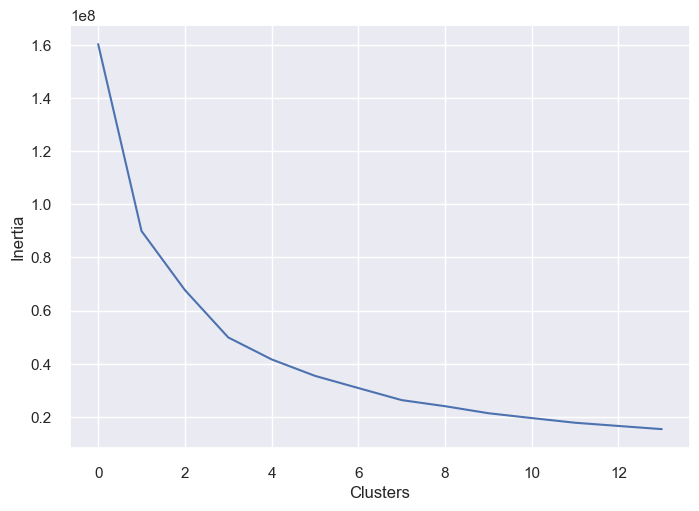

In [42]:
# Método do cotovelo para definir número de cluster:

clusters = []

for i in range(1, 15):
    km = KMeans(n_clusters=i).fit(X_cluster)
    clusters.append(km.inertia_)

plt.plot(clusters)
plt.xlabel('Clusters')
plt.ylabel('Inertia');

In [44]:
# 12 parece um bom número de cluster
km_12 = KMeans(n_clusters=12, random_state=42).fit(X_cluster)
df_train['store_cluster'] = km_12.labels_

# informações para log no mlflow
experiment_name = 'Clusterização de lojas - feature engineering'
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Kmeans_12'
run_name = model_name + ' - ' + date

mlflow.set_experiment(experiment_name)
mlflow.set_tracking_uri('http://127.0.0.1:5000')

with mlflow.start_run(run_name=run_name):
        
    mlflow.log_params(km_12.get_params())
    mlflow.sklearn.log_model(km_12, model_name)
mlflow.end_run()

2023/04/26 15:01:17 INFO mlflow.tracking.fluent: Experiment with name 'Clusterização de lojas - feature engineering' does not exist. Creating a new experiment.


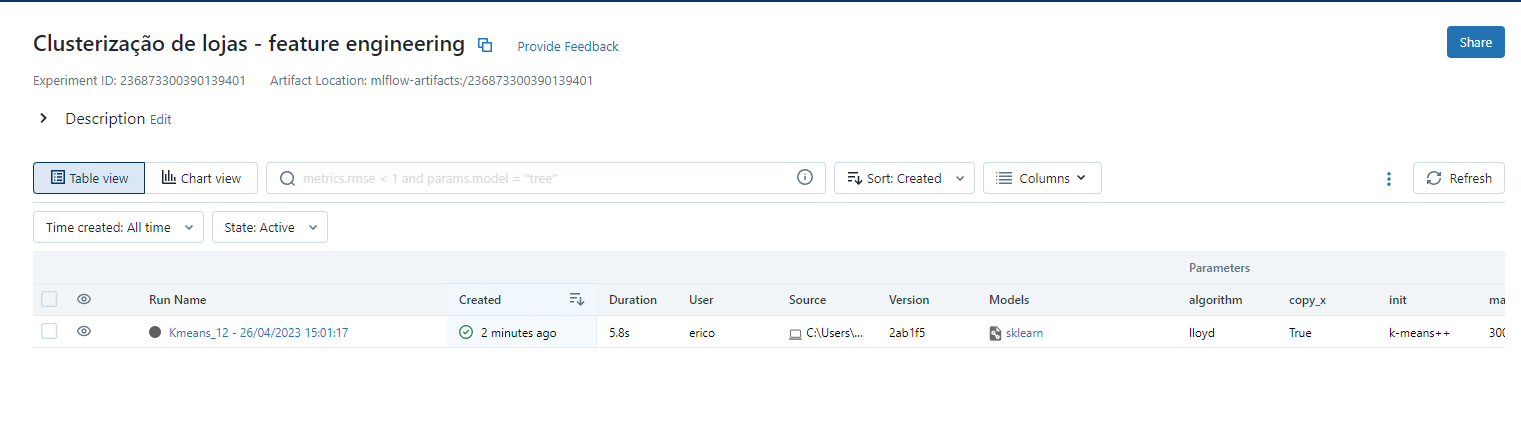

In [45]:
df_train.head()

store_id  store_area  items_available  daily_customer_count  store_sales  \
0         1        1659             1961                   530        66490   
1         2        1461             1752                   210        39820   
2         3        1340             1609                   720        54010   
3         4        1451             1748                   620        53730   
4         5        1770             2111                   450        46620   

   store_cluster  
0              0  
1              7  
2              1  
3              4  
4              0

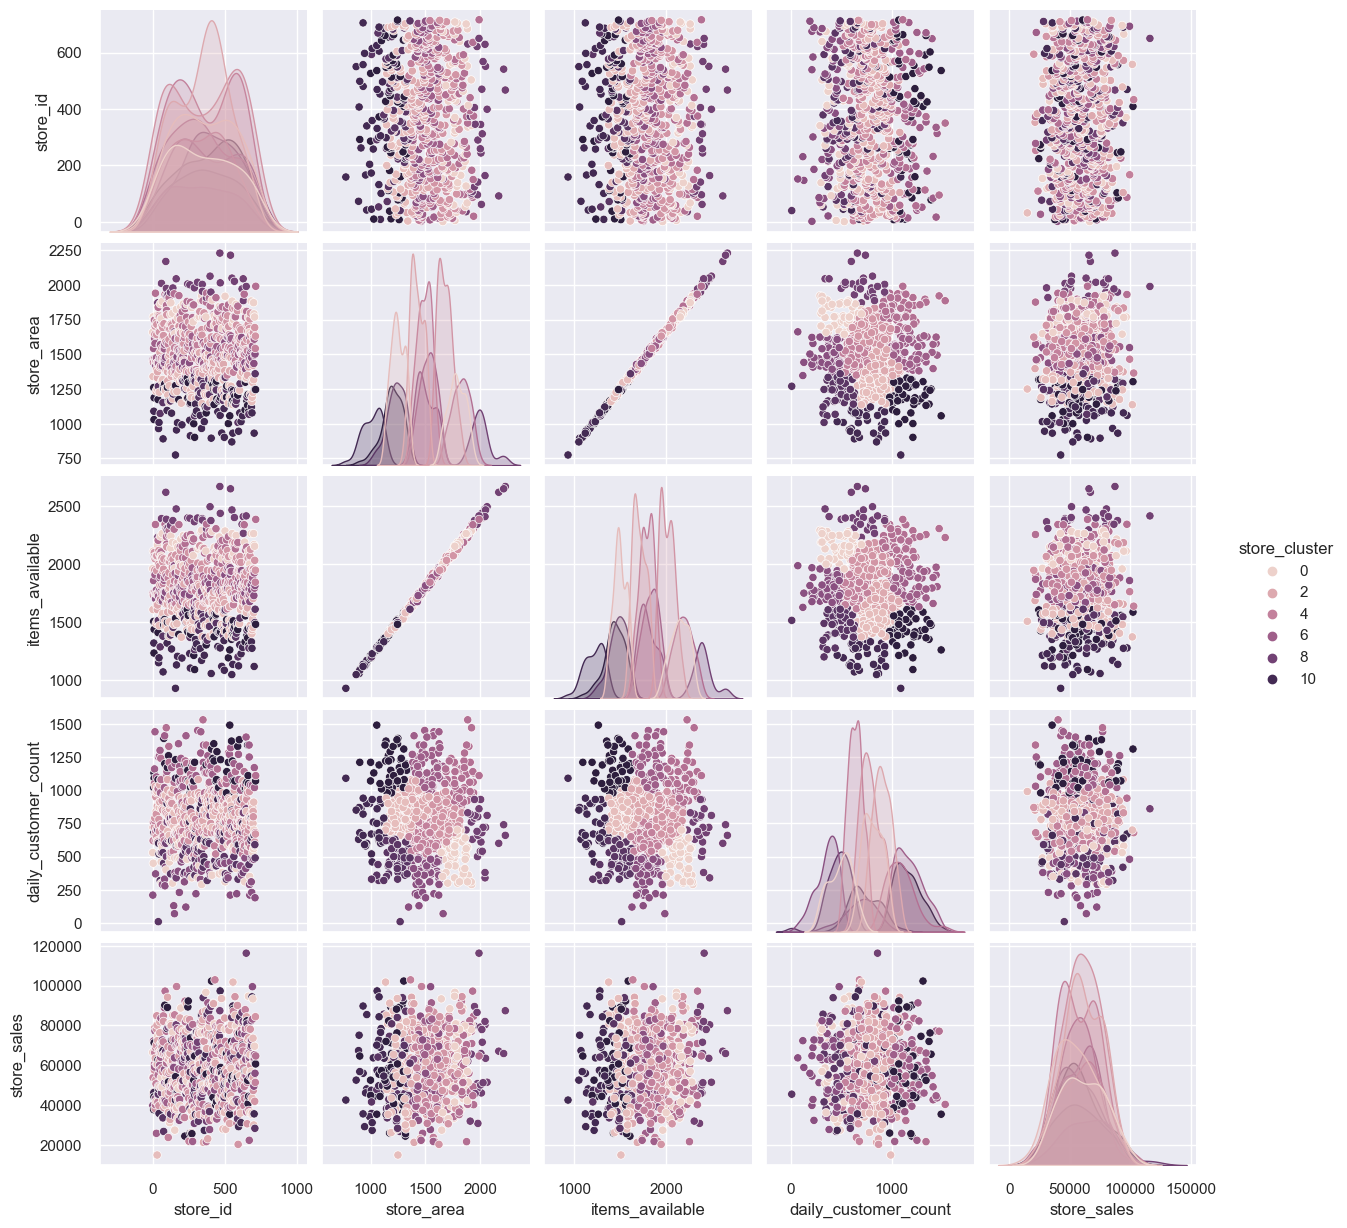

In [46]:
sns.pairplot(df_train, hue='store_cluster')

- Os agrupamentos conseguem dividir bem os grupos de vendas por variáveis analisando as imagens.

In [47]:
df_train.groupby('store_cluster')['store_sales'].sum().to_frame().sort_values(by='store_sales', ascending=False)

store_sales
store_cluster             
3                  5794430
2                  5277840
4                  5151620
1                  3873130
6                  3549340
5                  3134150
0                  3108770
7                  3056830
11                 2782710
9                  2669030
10                 2045950
8                  1772280

<Axes: title={'center': 'Store Sales by Cluster'}, xlabel='store_cluster'>

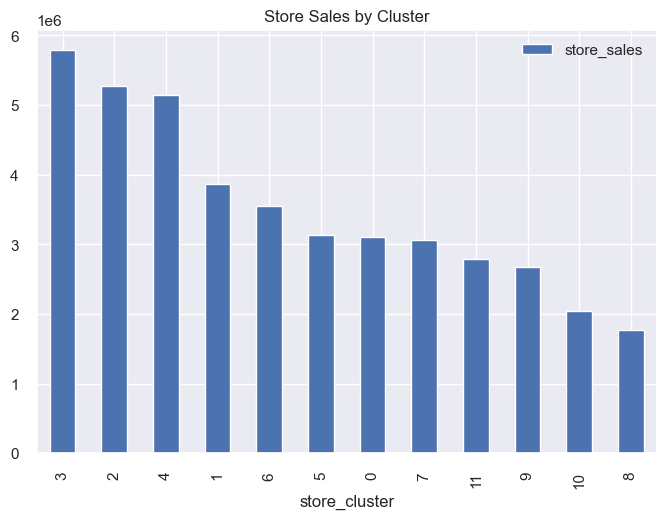

In [48]:
df_train.groupby('store_cluster')['store_sales'].sum().to_frame().sort_values(by='store_sales', ascending=False).plot(kind='bar', title='Store Sales by Cluster')

In [49]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()
corr.style.background_gradient(cmap= 'coolwarm')

- Os cluster têm uma correlação positiva fraca com o daily_customer_count.

## Split da base de treino

In [50]:
# Separar variáveis independentes e dependente
X = df_train.drop(['store_sales','daily_customer_count'], axis=1)
y = df_train['store_sales']

In [51]:
X.head()

store_id  store_area  items_available  store_cluster
0         1        1659             1961              0
1         2        1461             1752              7
2         3        1340             1609              1
3         4        1451             1748              4
4         5        1770             2111              0

In [52]:
y[:5]

0    66490
1    39820
2    54010
3    53730
4    46620
Name: store_sales, dtype: int64

## Treino/Validação

In [53]:
# definir função para treinar e validar os modelos e registrar os resultados dos experimentos

def train_validation_eval(model_name, model, X, y, gridsearch=False, params_grid=None, run_name=None, experiment_name=None, path_save_fig=None):
    

    logging.info("Função train_validation_eval iniciada")
    # listas de métricas para append futuro
    r2 = []
    rmse = []
    mape = []

    # inicializar variável best_model, best_param e default_params
    best_model = None
    best_param = None
    default_params = None

    logging.info("Iniciando loop de validação cruzada")
    # Cross validation
    n_splits = 5
    KFOLD = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0 

    # Split treino e validação hold out
    for train_ix, val_ix in KFOLD.split(X):
        fold+=1
        X_train, X_valid = X.iloc[train_ix, :], X.iloc[val_ix, :]
        y_train, y_valid = y.iloc[train_ix], y.iloc[val_ix]
        
        if gridsearch == False:
            logging.info(f"Treinando {model_name} com parâmetros padrão, fold {fold}")
            # Treino modelo default
            model.fit(X_train, y_train)
            logging.info(f"Prevendo conjunto de validação com {model_name} padrão, fold {fold}")
            # pegar parâtros default
            default_params = model.get_params()
            # Prever na validação
            yhat = model.predict(X_valid)
            
        else:
            logging.info(f"Treinando {model_name} com parâmetros otimizados pelo GridSearch, fold {fold}")
            # Definir espaço de gridsearch
            search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error', cv=KFOLD, n_jobs=-1)
            # Ajustar modelo
            search_result = search.fit(X_train, y_train)
            # melhor parâmetro
            best_param = search_result.best_params_
            # melhor modelo
            best_model = search_result.best_estimator_
            logging.info(f"Prevendo conjunto de validação com {model_name} otimizado, fold {fold}")
            # Prever na validação com melhor modelo
            yhat = best_model.predict(X_valid)
        
        logging.info("Avaliando resultados nos dados de validação")
        #Avaliação numerica
        R2 = r2_score(y_valid, yhat)
        r2.append(R2)
        RMSE = np.sqrt(mean_squared_error(y_valid, yhat))
        rmse.append(RMSE)
        MAPE = mean_absolute_percentage_error(y_valid, yhat)
        mape.append(MAPE)
        
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_valid, yhat, 1)
    plt.scatter(y_valid, yhat, alpha=0.5)
    plt.plot(y_valid, np.polyval(p, y_valid), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_valid - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()

    # Avaliação na validação
    print(f"Modelo:  {model_name}")
    print(f"R2 CV:   {np.mean(r2):.2f}")
    print(f"RMSE CV: {np.mean(rmse):.2f}")
    print(f"MAPE CV: {np.mean(mape)*100:.2f}%")
    
    if gridsearch == True:
        # Imprimir melhor parâmetro e modelo após o loop de validação cruzada
        print(f"Melhores parâmetros: {best_param}")
        print(f"Melhor modelo: {best_model}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        
        if best_param is not None:  
            mlflow.log_params(best_param)
            
        if default_params is not None:
            mlflow.log_params(default_params)
            
        mlflow.log_metrics({'R2 CV': np.mean(r2),
                            'RMSE CV': np.mean(rmse),
                            'MAPE CV': np.mean(mape)
                           })
        
        try:
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        except:
            pass
        
        for framework in [mlflow.sklearn, mlflow.xgboost, mlflow.lightgbm, mlflow.catboost]:
            try:
                framework.log_model(model, model_name)
                break
            except Exception:
                pass
        
    mlflow.end_run()
        
    return logging.info('Ciclo de vida dos modelos rastreado com sucesso!')


### Algoritmos com parâmetros padrão

In [54]:
path_save_fig = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\reports\figures'

2023-04-26 15:20:00,322 - Função train_validation_eval iniciada
2023-04-26 15:20:00,324 - Iniciando loop de validação cruzada
2023-04-26 15:20:00,328 - Treinando LinearRegression com parâmetros padrão, fold 1
2023-04-26 15:20:00,333 - Prevendo conjunto de validação com LinearRegression padrão, fold 1
2023-04-26 15:20:00,336 - Avaliando resultados nos dados de validação
2023-04-26 15:20:00,338 - Treinando LinearRegression com parâmetros padrão, fold 2
2023-04-26 15:20:00,341 - Prevendo conjunto de validação com LinearRegression padrão, fold 2
2023-04-26 15:20:00,343 - Avaliando resultados nos dados de validação
2023-04-26 15:20:00,347 - Treinando LinearRegression com parâmetros padrão, fold 3
2023-04-26 15:20:00,350 - Prevendo conjunto de validação com LinearRegression padrão, fold 3
2023-04-26 15:20:00,353 - Avaliando resultados nos dados de validação
2023-04-26 15:20:00,356 - Treinando LinearRegression com parâmetros padrão, fold 4
2023-04-26 15:20:00,359 - Prevendo conjunto de valida

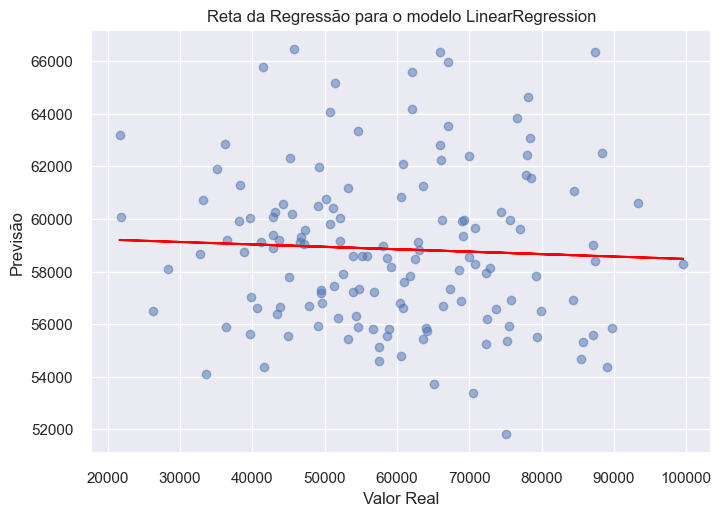

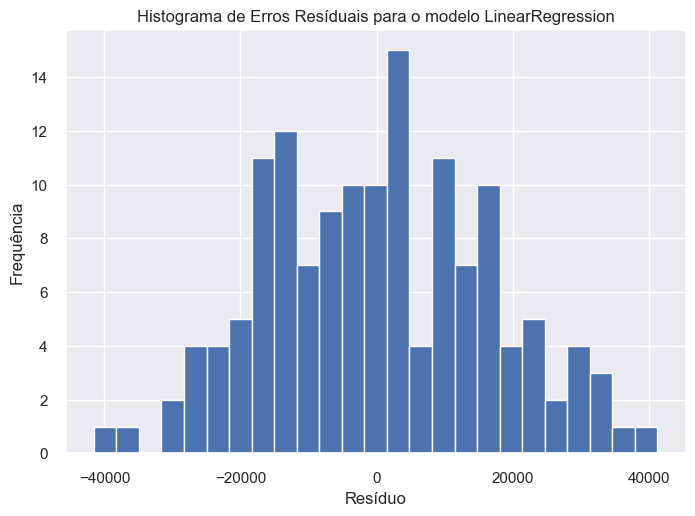

2023-04-26 15:20:01,182 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/26 15:20:01 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com parâmetros padrão - treino e validação' does not exist. Creating a new experiment.


Modelo:  LinearRegression
R2 CV:   -0.00
RMSE CV: 16956.42
MAPE CV: 27.85%


2023-04-26 15:20:09,098 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:09,098 - Função train_validation_eval iniciada
2023-04-26 15:20:09,100 - Iniciando loop de validação cruzada
2023-04-26 15:20:09,102 - Treinando RandomForestRegressor com parâmetros padrão, fold 1
2023-04-26 15:20:09,375 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 1
2023-04-26 15:20:09,384 - Avaliando resultados nos dados de validação
2023-04-26 15:20:09,389 - Treinando RandomForestRegressor com parâmetros padrão, fold 2
2023-04-26 15:20:09,645 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 2
2023-04-26 15:20:09,653 - Avaliando resultados nos dados de validação
2023-04-26 15:20:09,657 - Treinando RandomForestRegressor com parâmetros padrão, fold 3
2023-04-26 15:20:09,906 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 3
2023-04-26 15:20:09,916 - Avaliando resultados nos dados de validação
2023-04-26 15:20:09,919 - Trein

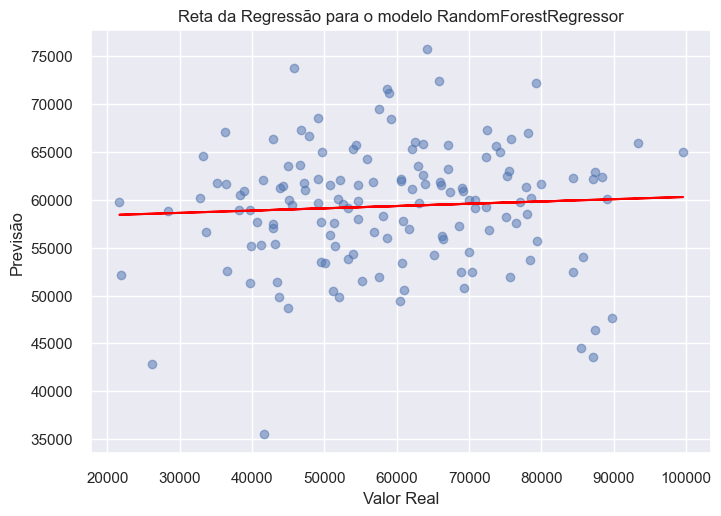

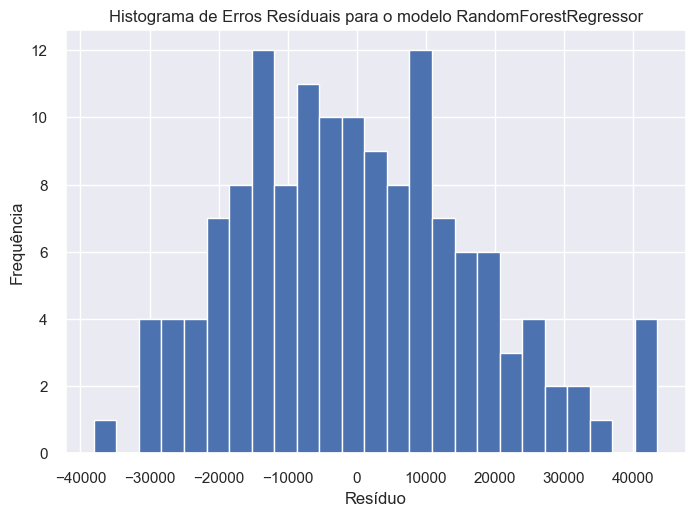

2023-04-26 15:20:11,265 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor
R2 CV:   -0.10
RMSE CV: 17712.98
MAPE CV: 28.52%


2023-04-26 15:20:15,470 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:15,471 - Função train_validation_eval iniciada
2023-04-26 15:20:15,472 - Iniciando loop de validação cruzada
2023-04-26 15:20:15,476 - Treinando Ridge com parâmetros padrão, fold 1
2023-04-26 15:20:15,479 - Prevendo conjunto de validação com Ridge padrão, fold 1
2023-04-26 15:20:15,482 - Avaliando resultados nos dados de validação
2023-04-26 15:20:15,486 - Treinando Ridge com parâmetros padrão, fold 2
2023-04-26 15:20:15,488 - Prevendo conjunto de validação com Ridge padrão, fold 2
2023-04-26 15:20:15,491 - Avaliando resultados nos dados de validação
2023-04-26 15:20:15,495 - Treinando Ridge com parâmetros padrão, fold 3
2023-04-26 15:20:15,499 - Prevendo conjunto de validação com Ridge padrão, fold 3
2023-04-26 15:20:15,501 - Avaliando resultados nos dados de validação
2023-04-26 15:20:15,505 - Treinando Ridge com parâmetros padrão, fold 4
2023-04-26 15:20:15,508 - Prevendo conjunto de validaçã

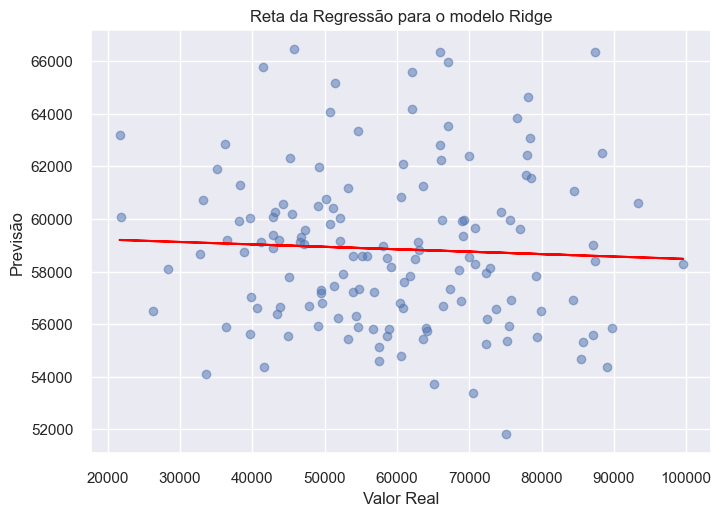

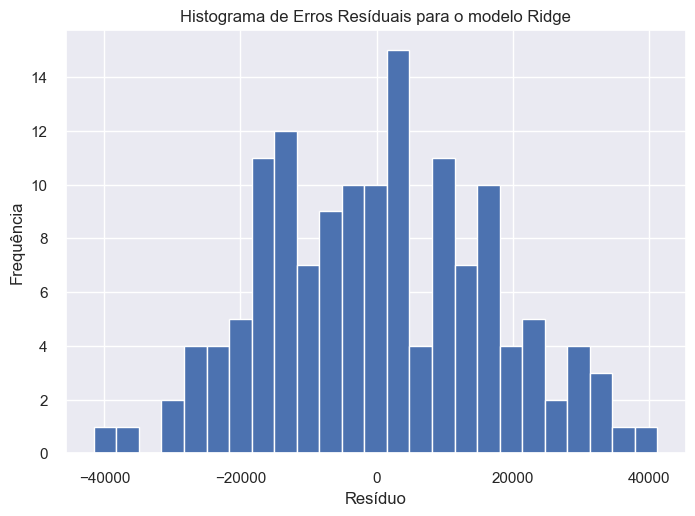

2023-04-26 15:20:16,280 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Ridge
R2 CV:   -0.00
RMSE CV: 16956.41
MAPE CV: 27.85%


2023-04-26 15:20:20,072 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:20,072 - Função train_validation_eval iniciada
2023-04-26 15:20:20,074 - Iniciando loop de validação cruzada
2023-04-26 15:20:20,077 - Treinando Lasso com parâmetros padrão, fold 1
2023-04-26 15:20:20,081 - Prevendo conjunto de validação com Lasso padrão, fold 1
2023-04-26 15:20:20,084 - Avaliando resultados nos dados de validação
2023-04-26 15:20:20,086 - Treinando Lasso com parâmetros padrão, fold 2
2023-04-26 15:20:20,091 - Prevendo conjunto de validação com Lasso padrão, fold 2
2023-04-26 15:20:20,094 - Avaliando resultados nos dados de validação
2023-04-26 15:20:20,096 - Treinando Lasso com parâmetros padrão, fold 3
2023-04-26 15:20:20,100 - Prevendo conjunto de validação com Lasso padrão, fold 3
2023-04-26 15:20:20,103 - Avaliando resultados nos dados de validação
2023-04-26 15:20:20,106 - Treinando Lasso com parâmetros padrão, fold 4
2023-04-26 15:20:20,111 - Prevendo conjunto de validaçã

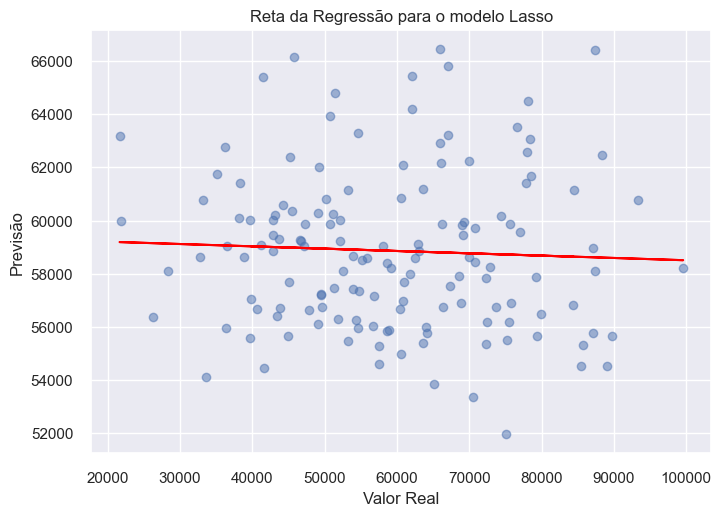

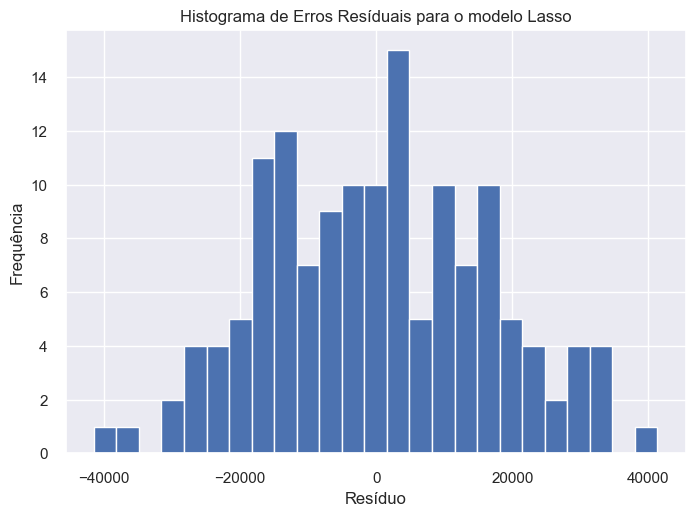

2023-04-26 15:20:20,893 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso
R2 CV:   -0.00
RMSE CV: 16952.55
MAPE CV: 27.84%


2023-04-26 15:20:24,815 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:24,816 - Função train_validation_eval iniciada
2023-04-26 15:20:24,816 - Iniciando loop de validação cruzada
2023-04-26 15:20:24,820 - Treinando ElasticNet com parâmetros padrão, fold 1
2023-04-26 15:20:24,824 - Prevendo conjunto de validação com ElasticNet padrão, fold 1
2023-04-26 15:20:24,825 - Avaliando resultados nos dados de validação
2023-04-26 15:20:24,828 - Treinando ElasticNet com parâmetros padrão, fold 2
2023-04-26 15:20:24,833 - Prevendo conjunto de validação com ElasticNet padrão, fold 2
2023-04-26 15:20:24,835 - Avaliando resultados nos dados de validação
2023-04-26 15:20:24,839 - Treinando ElasticNet com parâmetros padrão, fold 3
2023-04-26 15:20:24,842 - Prevendo conjunto de validação com ElasticNet padrão, fold 3
2023-04-26 15:20:24,845 - Avaliando resultados nos dados de validação
2023-04-26 15:20:24,848 - Treinando ElasticNet com parâmetros padrão, fold 4
2023-04-26 15:20:24,

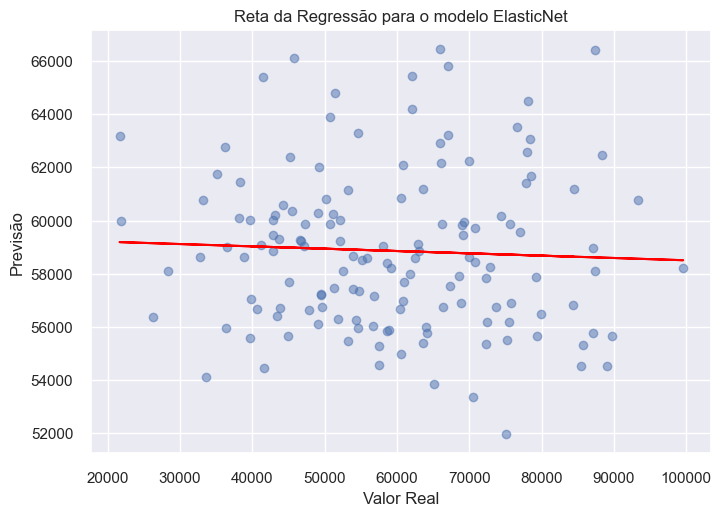

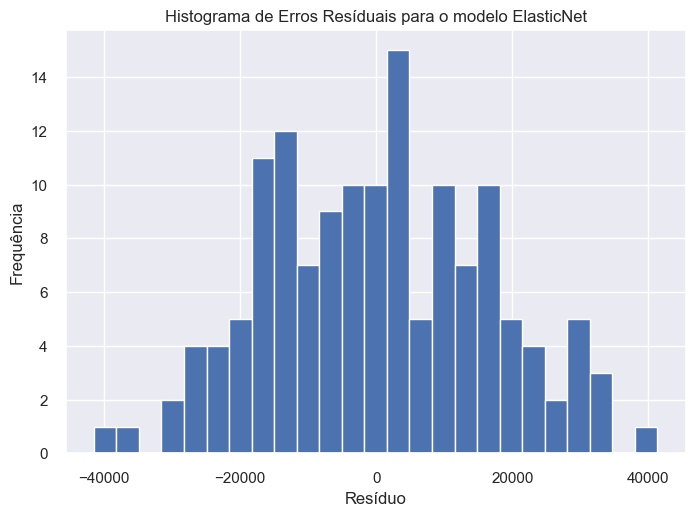

2023-04-26 15:20:25,624 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  ElasticNet
R2 CV:   -0.00
RMSE CV: 16951.28
MAPE CV: 27.84%


2023-04-26 15:20:29,445 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:29,446 - Função train_validation_eval iniciada
2023-04-26 15:20:29,447 - Iniciando loop de validação cruzada
2023-04-26 15:20:29,450 - Treinando SVR com parâmetros padrão, fold 1
2023-04-26 15:20:29,467 - Prevendo conjunto de validação com SVR padrão, fold 1
2023-04-26 15:20:29,476 - Avaliando resultados nos dados de validação
2023-04-26 15:20:29,480 - Treinando SVR com parâmetros padrão, fold 2
2023-04-26 15:20:29,492 - Prevendo conjunto de validação com SVR padrão, fold 2
2023-04-26 15:20:29,502 - Avaliando resultados nos dados de validação
2023-04-26 15:20:29,504 - Treinando SVR com parâmetros padrão, fold 3
2023-04-26 15:20:29,517 - Prevendo conjunto de validação com SVR padrão, fold 3
2023-04-26 15:20:29,524 - Avaliando resultados nos dados de validação
2023-04-26 15:20:29,528 - Treinando SVR com parâmetros padrão, fold 4
2023-04-26 15:20:29,540 - Prevendo conjunto de validação com SVR padr

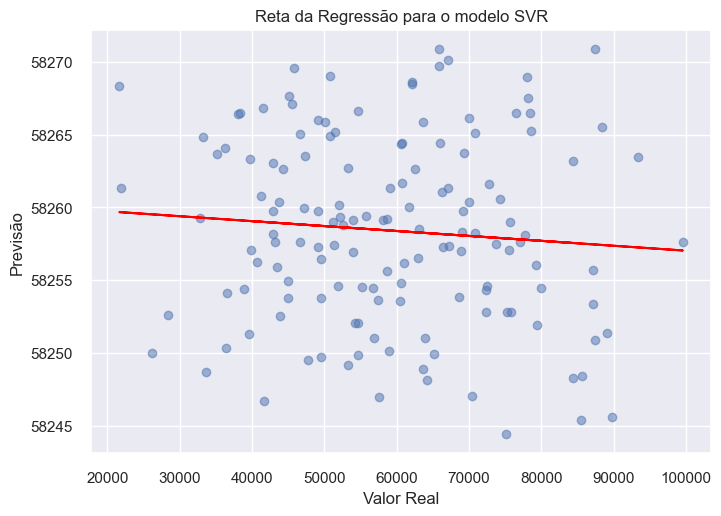

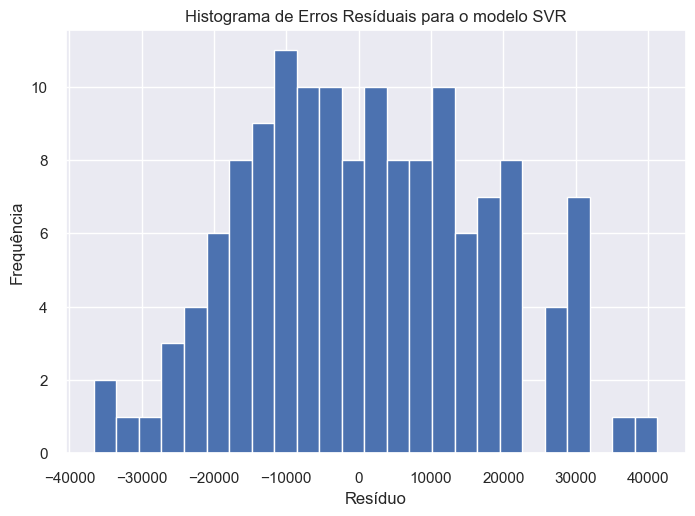

2023-04-26 15:20:30,388 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  SVR
R2 CV:   -0.01
RMSE CV: 16985.21
MAPE CV: 27.71%


2023-04-26 15:20:33,985 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:33,985 - Função train_validation_eval iniciada
2023-04-26 15:20:33,985 - Iniciando loop de validação cruzada
2023-04-26 15:20:33,989 - Treinando MLPRegressor com parâmetros padrão, fold 1
2023-04-26 15:20:34,609 - Prevendo conjunto de validação com MLPRegressor padrão, fold 1
2023-04-26 15:20:34,611 - Avaliando resultados nos dados de validação
2023-04-26 15:20:34,615 - Treinando MLPRegressor com parâmetros padrão, fold 2
2023-04-26 15:20:35,245 - Prevendo conjunto de validação com MLPRegressor padrão, fold 2
2023-04-26 15:20:35,248 - Avaliando resultados nos dados de validação
2023-04-26 15:20:35,250 - Treinando MLPRegressor com parâmetros padrão, fold 3
2023-04-26 15:20:35,845 - Prevendo conjunto de validação com MLPRegressor padrão, fold 3
2023-04-26 15:20:35,849 - Avaliando resultados nos dados de validação
2023-04-26 15:20:35,852 - Treinando MLPRegressor com parâmetros padrão, fold 4
2023-0

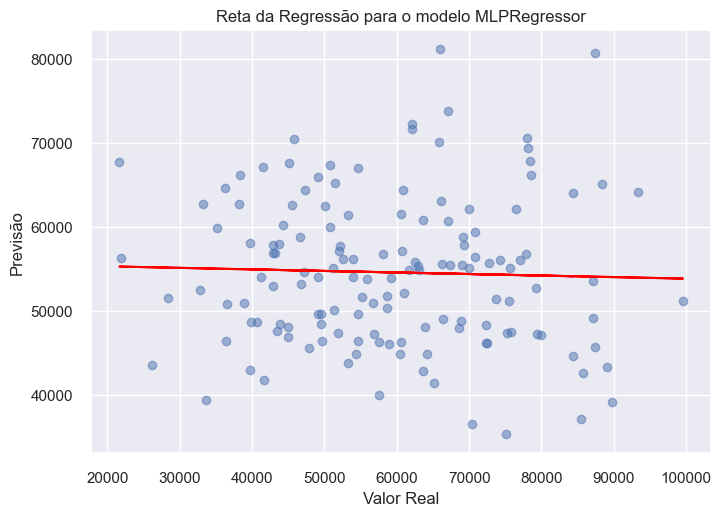

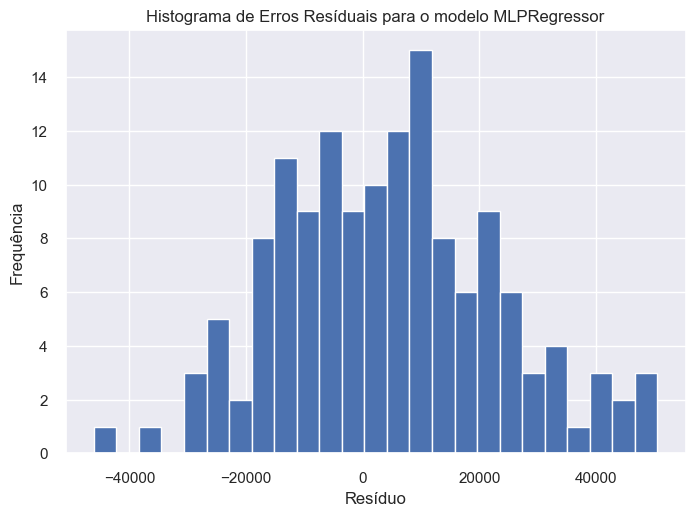

2023-04-26 15:20:37,856 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  MLPRegressor
R2 CV:   -0.22
RMSE CV: 18648.86
MAPE CV: 27.77%


2023-04-26 15:20:41,751 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:41,751 - Função train_validation_eval iniciada
2023-04-26 15:20:41,752 - Iniciando loop de validação cruzada
2023-04-26 15:20:41,755 - Treinando XGBRegressor com parâmetros padrão, fold 1
2023-04-26 15:20:41,861 - Prevendo conjunto de validação com XGBRegressor padrão, fold 1
2023-04-26 15:20:41,867 - Avaliando resultados nos dados de validação
2023-04-26 15:20:41,878 - Treinando XGBRegressor com parâmetros padrão, fold 2
2023-04-26 15:20:41,983 - Prevendo conjunto de validação com XGBRegressor padrão, fold 2
2023-04-26 15:20:41,988 - Avaliando resultados nos dados de validação
2023-04-26 15:20:41,992 - Treinando XGBRegressor com parâmetros padrão, fold 3
2023-04-26 15:20:42,094 - Prevendo conjunto de validação com XGBRegressor padrão, fold 3
2023-04-26 15:20:42,098 - Avaliando resultados nos dados de validação
2023-04-26 15:20:42,110 - Treinando XGBRegressor com parâmetros padrão, fold 4
2023-0

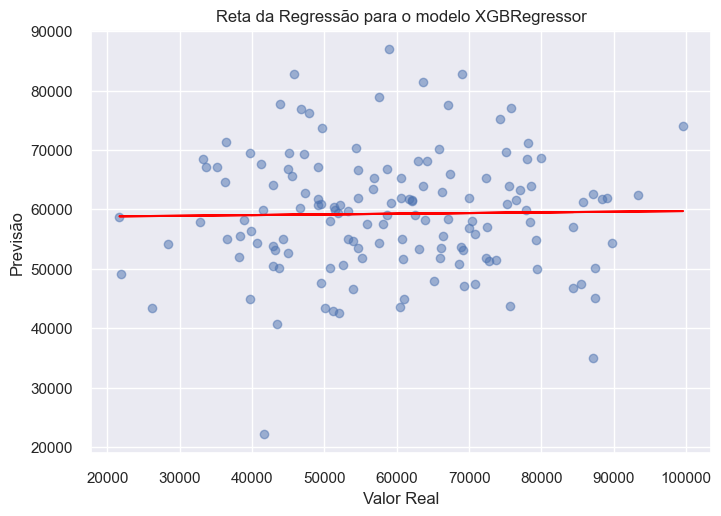

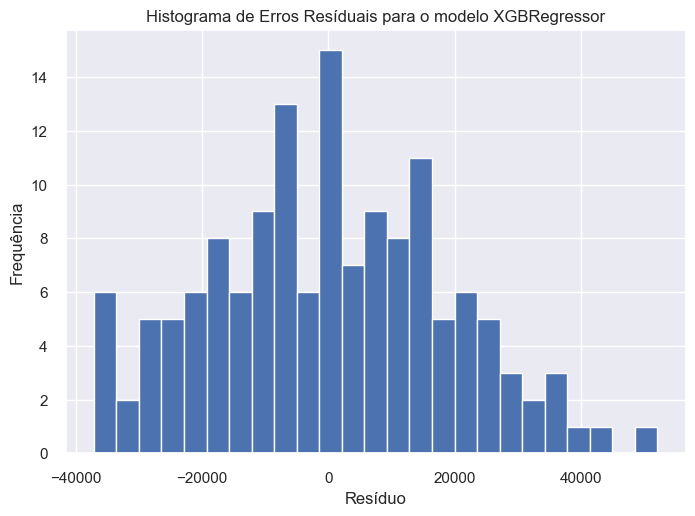

2023-04-26 15:20:43,165 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  XGBRegressor
R2 CV:   -0.36
RMSE CV: 19741.77
MAPE CV: 31.31%


2023-04-26 15:20:47,049 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:47,050 - Função train_validation_eval iniciada
2023-04-26 15:20:47,051 - Iniciando loop de validação cruzada
2023-04-26 15:20:47,055 - Treinando LGBMRegressor com parâmetros padrão, fold 1
2023-04-26 15:20:47,141 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 1
2023-04-26 15:20:47,154 - Avaliando resultados nos dados de validação
2023-04-26 15:20:47,159 - Treinando LGBMRegressor com parâmetros padrão, fold 2
2023-04-26 15:20:47,240 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 2
2023-04-26 15:20:47,243 - Avaliando resultados nos dados de validação
2023-04-26 15:20:47,246 - Treinando LGBMRegressor com parâmetros padrão, fold 3
2023-04-26 15:20:47,326 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 3
2023-04-26 15:20:47,337 - Avaliando resultados nos dados de validação
2023-04-26 15:20:47,343 - Treinando LGBMRegressor com parâmetros padrão, fold 4

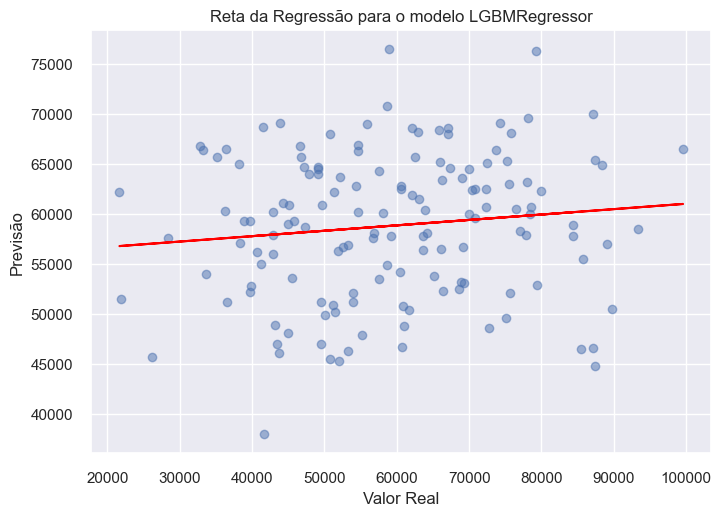

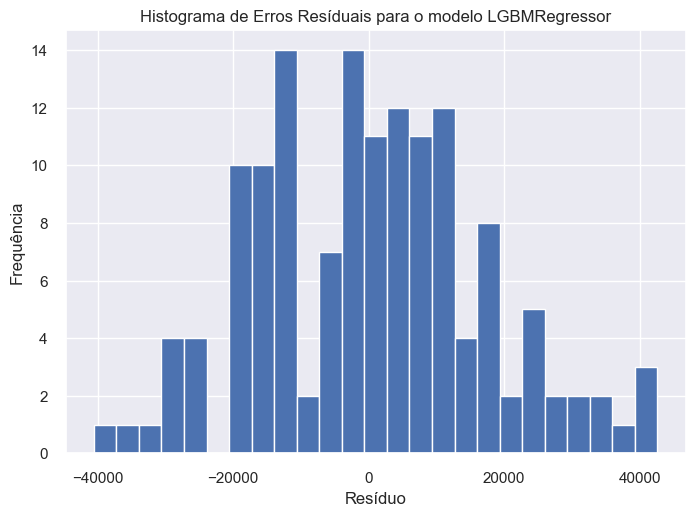

2023-04-26 15:20:48,337 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LGBMRegressor
R2 CV:   -0.14
RMSE CV: 18085.80
MAPE CV: 28.93%


2023-04-26 15:20:52,631 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-26 15:20:52,632 - Função train_validation_eval iniciada
2023-04-26 15:20:52,633 - Iniciando loop de validação cruzada
2023-04-26 15:20:52,636 - Treinando CatBoostRegressor com parâmetros padrão, fold 1
2023-04-26 15:20:53,931 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 1
2023-04-26 15:20:53,935 - Avaliando resultados nos dados de validação
2023-04-26 15:20:53,939 - Treinando CatBoostRegressor com parâmetros padrão, fold 2
2023-04-26 15:20:55,103 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 2
2023-04-26 15:20:55,106 - Avaliando resultados nos dados de validação
2023-04-26 15:20:55,110 - Treinando CatBoostRegressor com parâmetros padrão, fold 3
2023-04-26 15:20:56,245 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 3
2023-04-26 15:20:56,248 - Avaliando resultados nos dados de validação
2023-04-26 15:20:56,252 - Treinando CatBoostRegressor c

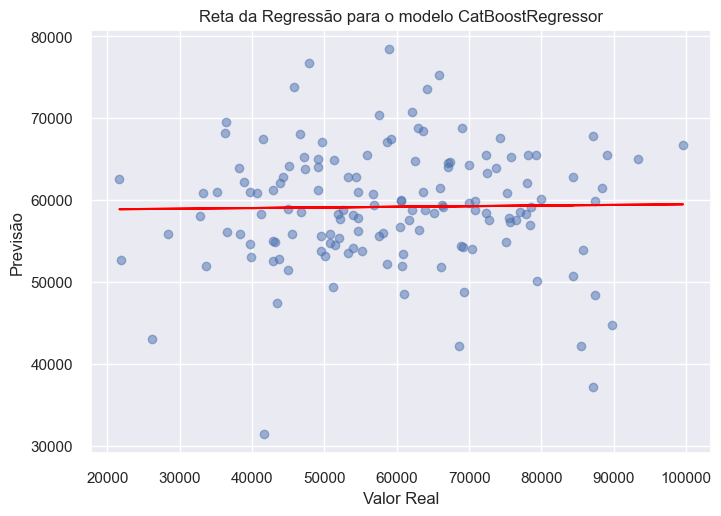

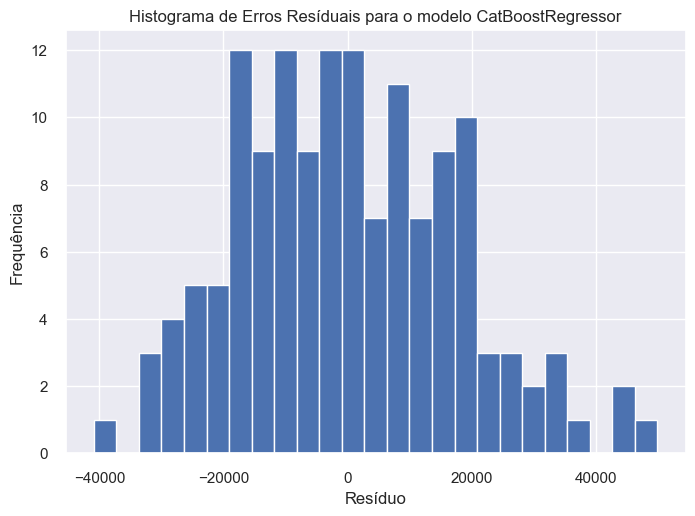

2023-04-26 15:20:59,384 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  CatBoostRegressor
R2 CV:   -0.12
RMSE CV: 17897.03
MAPE CV: 29.03%


2023-04-26 15:21:03,726 - Ciclo de vida dos modelos rastreado com sucesso!


In [55]:
# definir lista de algoritmos a serem testados
algoritmos = [
    ('LinearRegression', LinearRegression(n_jobs=-1)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('SVR', SVR()),
    ('MLPRegressor', MLPRegressor(early_stopping=True)),
    ('XGBRegressor', XGBRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('CatBoostRegressor', CatBoostRegressor(verbose=False))
]

experiment_name = 'Modelos com parâmetros padrão - treino e validação'

# Treinar e validar os vários algoritmos acima:
for model_name, model in algoritmos:
    
    # Executar função sem GridSearch
    date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    model_name_date = model_name + ' - ' + date
    
    train_validation_eval(model_name=model_name, model=model, X=X, y=y, gridsearch=False, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

#### Resultados 



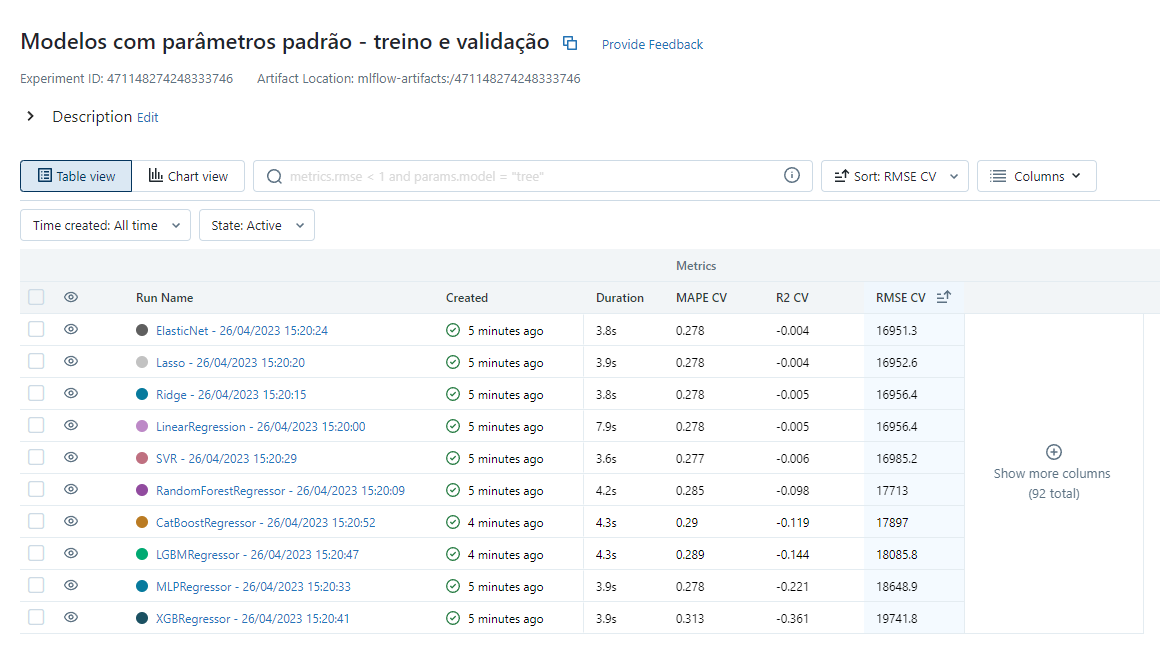

### GridSearch nos modelos que tendem a ter melhores resultados otimizados

#### ElasticNet

In [56]:
# # definir algoritmo a ser otimizado
# Elastic = ElasticNet()

# # define os hiperparâmetros a serem testados
# params = {
#     'alpha': [0.1, 0.5, 1.0, 2.0],
#     'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
#     'max_iter': [100, 500, 1000],
#     'tol': [1e-3, 1e-4, 1e-5],
#     'fit_intercept': [True, False]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'ElasticNet'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=Elastic, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:03,217 - Função train_validation_eval iniciada
2023-04-26 15:26:03,219 - Iniciando loop de validação cruzada
2023-04-26 15:26:03,222 - Treinando Elastic_opt com parâmetros padrão, fold 1
2023-04-26 15:26:03,226 - Prevendo conjunto de validação com Elastic_opt padrão, fold 1
2023-04-26 15:26:03,229 - Avaliando resultados nos dados de validação
2023-04-26 15:26:03,231 - Treinando Elastic_opt com parâmetros padrão, fold 2
2023-04-26 15:26:03,235 - Prevendo conjunto de validação com Elastic_opt padrão, fold 2
2023-04-26 15:26:03,237 - Avaliando resultados nos dados de validação
2023-04-26 15:26:03,241 - Treinando Elastic_opt com parâmetros padrão, fold 3
2023-04-26 15:26:03,244 - Prevendo conjunto de validação com Elastic_opt padrão, fold 3
2023-04-26 15:26:03,247 - Avaliando resultados nos dados de validação
2023-04-26 15:26:03,252 - Treinando Elastic_opt com parâmetros padrão, fold 4
2023-04-26 15:26:03,255 - Prevendo conjunto de validação com Elastic_opt padrão, fold 4


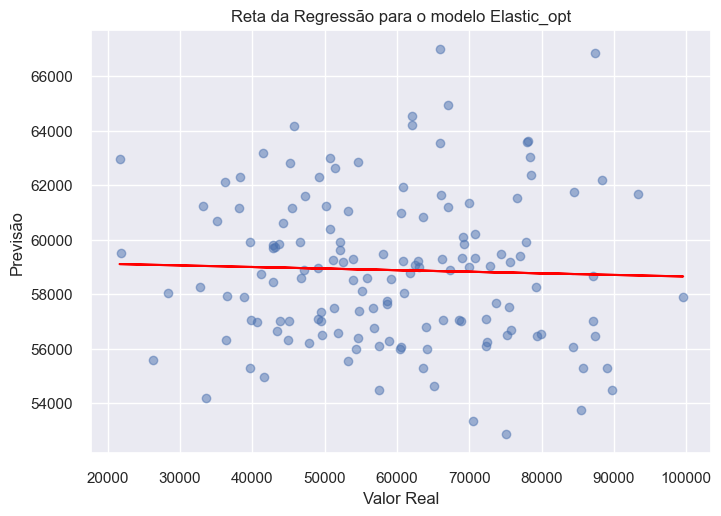

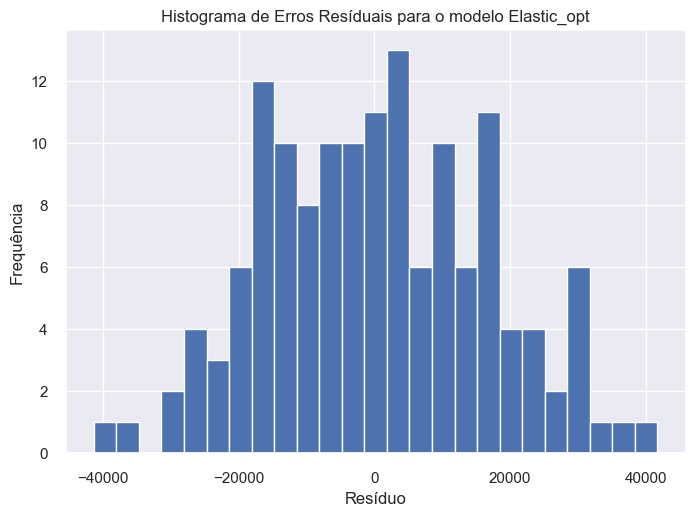

2023-04-26 15:26:04,004 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/26 15:26:04 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com hiperparâmetros tunados - treino e validação' does not exist. Creating a new experiment.


Modelo:  Elastic_opt
R2 CV:   -0.00
RMSE CV: 16936.71
MAPE CV: 27.81%


2023-04-26 15:26:08,049 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 734 ms
Wall time: 4.83 s


In [57]:
%%time
# Retreinando modelo otimizado com novos hiperparâmetros
Elastic_opt = ElasticNet(alpha=2.0, l1_ratio=0.1, fit_intercept=True, max_iter=100, tol=0.001)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=Elastic_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### Lasso

In [58]:
# # definir algoritmo a ser otimizado
# lasso_opt = Lasso(random_state=42)

# # define os hiperparâmetros a serem testados
# params = {
#             'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#             'fit_intercept': [True, False],
#             'max_iter': [1000, 5000, 10000],
#             'selection':['cyclic', 'random'],
#             'tol': [1e-3, 1e-4, 1e-5]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'Lasso_opt'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=lasso_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:08,087 - Função train_validation_eval iniciada
2023-04-26 15:26:08,089 - Iniciando loop de validação cruzada
2023-04-26 15:26:08,092 - Treinando Lasso_opt com parâmetros padrão, fold 1
2023-04-26 15:26:08,099 - Prevendo conjunto de validação com Lasso_opt padrão, fold 1
2023-04-26 15:26:08,100 - Avaliando resultados nos dados de validação
2023-04-26 15:26:08,104 - Treinando Lasso_opt com parâmetros padrão, fold 2
2023-04-26 15:26:08,108 - Prevendo conjunto de validação com Lasso_opt padrão, fold 2
2023-04-26 15:26:08,111 - Avaliando resultados nos dados de validação
2023-04-26 15:26:08,114 - Treinando Lasso_opt com parâmetros padrão, fold 3
2023-04-26 15:26:08,119 - Prevendo conjunto de validação com Lasso_opt padrão, fold 3
2023-04-26 15:26:08,121 - Avaliando resultados nos dados de validação
2023-04-26 15:26:08,125 - Treinando Lasso_opt com parâmetros padrão, fold 4
2023-04-26 15:26:08,129 - Prevendo conjunto de validação com Lasso_opt padrão, fold 4
2023-04-26 15:26

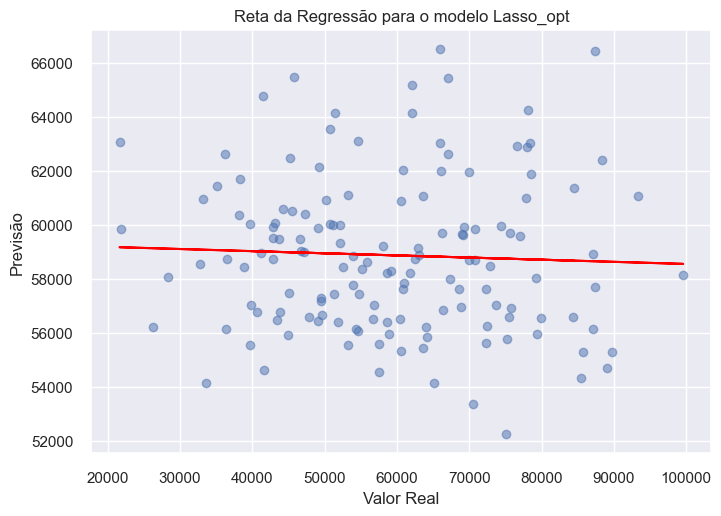

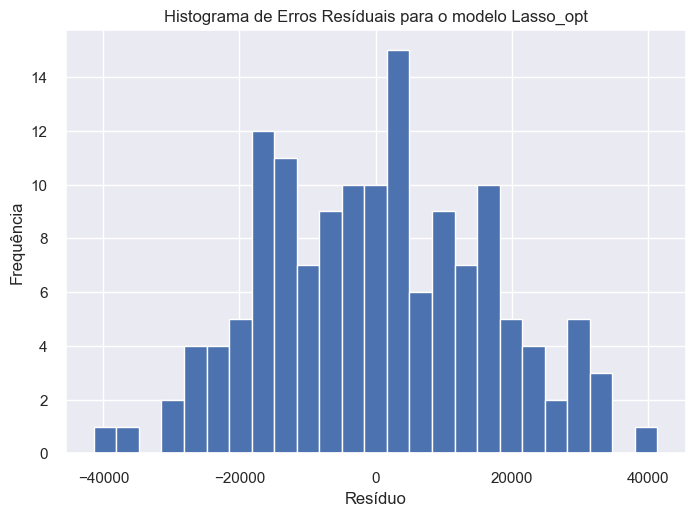

2023-04-26 15:26:08,914 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso_opt
R2 CV:   -0.00
RMSE CV: 16944.95
MAPE CV: 27.83%


2023-04-26 15:26:12,626 - Ciclo de vida dos modelos rastreado com sucesso!


In [59]:
# Retreinando modelo otimizado com novos hiperparâmetros
lasso_opt = Lasso(**{'alpha': 100, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random', 'tol': 1e-05})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=lasso_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### LinearRegression

In [60]:
# # definir algoritmo a ser otimizado
# linear_regression_opt = LinearRegression(n_jobs=-1)

# # define os hiperparâmetros a serem testados
# params = {
#     'fit_intercept': [True, False],
#     'positive': [True, False]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'LinearRegression_opt'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=linear_regression_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:12,668 - Função train_validation_eval iniciada
2023-04-26 15:26:12,669 - Iniciando loop de validação cruzada
2023-04-26 15:26:12,673 - Treinando LinearRegression_opt com parâmetros padrão, fold 1
2023-04-26 15:26:12,678 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 1
2023-04-26 15:26:12,680 - Avaliando resultados nos dados de validação
2023-04-26 15:26:12,685 - Treinando LinearRegression_opt com parâmetros padrão, fold 2
2023-04-26 15:26:12,689 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 2
2023-04-26 15:26:12,692 - Avaliando resultados nos dados de validação
2023-04-26 15:26:12,696 - Treinando LinearRegression_opt com parâmetros padrão, fold 3
2023-04-26 15:26:12,700 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 3
2023-04-26 15:26:12,702 - Avaliando resultados nos dados de validação
2023-04-26 15:26:12,705 - Treinando LinearRegression_opt com parâmetros padrão, fold 4
2023-04-26 15:26:12,710 -

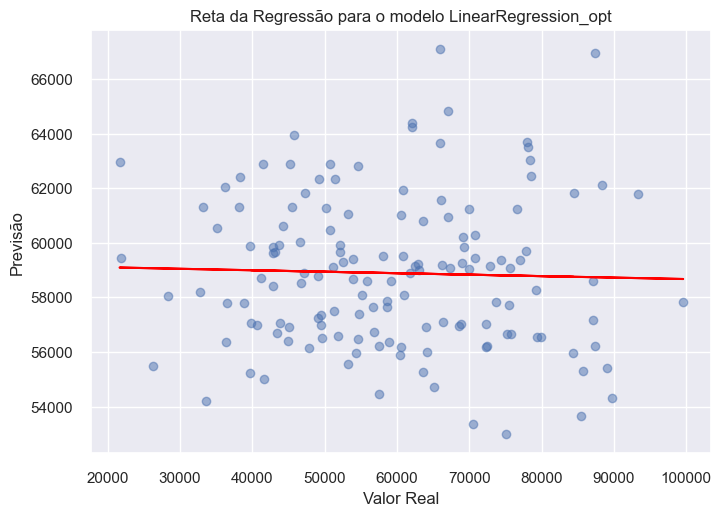

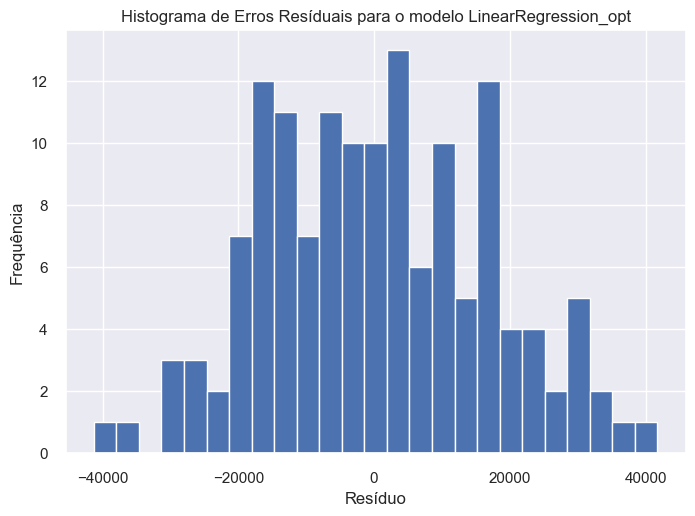

2023-04-26 15:26:13,445 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LinearRegression_opt
R2 CV:   -0.00
RMSE CV: 16934.52
MAPE CV: 27.81%


2023-04-26 15:26:16,926 - Ciclo de vida dos modelos rastreado com sucesso!


In [61]:
# Retreinando modelo otimizado com novos hiperparâmetros
linear_regression_opt = LinearRegression(**{'fit_intercept': True, 'positive': True})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'LinearRegression_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=linear_regression_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### RandomForestRegressor

2023-04-26 15:26:16,946 - Função train_validation_eval iniciada
2023-04-26 15:26:16,947 - Iniciando loop de validação cruzada
2023-04-26 15:26:16,951 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 1
2023-04-26 15:26:17,189 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 1
2023-04-26 15:26:17,203 - Avaliando resultados nos dados de validação
2023-04-26 15:26:17,206 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 2
2023-04-26 15:26:17,422 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 2
2023-04-26 15:26:17,436 - Avaliando resultados nos dados de validação
2023-04-26 15:26:17,439 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 3
2023-04-26 15:26:17,657 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 3
2023-04-26 15:26:17,671 - Avaliando resultados nos dados de validação
2023-04-26 15:26:17,674 - Treinando RandomForestRegressor_opt com parâmetros padrã

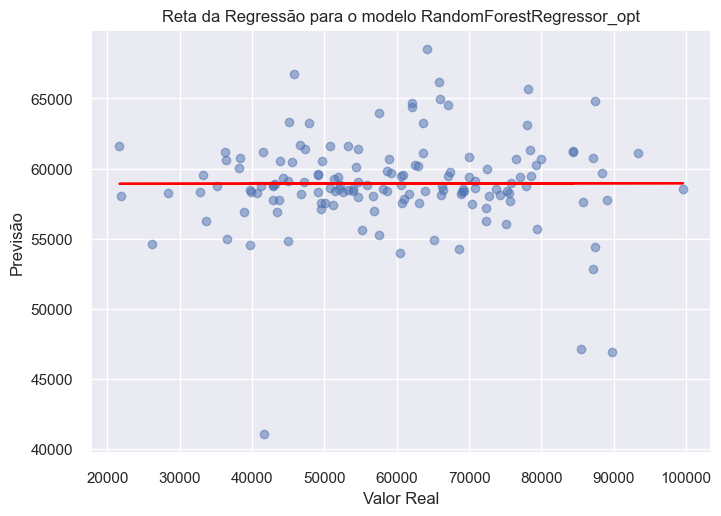

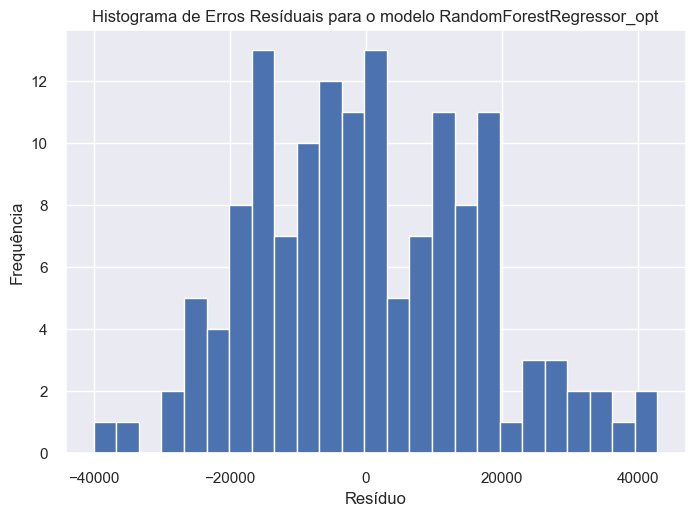

2023-04-26 15:26:18,852 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor_opt
R2 CV:   -0.01
RMSE CV: 17022.59
MAPE CV: 27.91%


2023-04-26 15:26:22,835 - Ciclo de vida dos modelos rastreado com sucesso!


In [62]:
# modelo otimizado com novos hiperparâmetros
rfr_opt = RandomForestRegressor(bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=200, random_state=42, min_samples_leaf=1, min_samples_split=2)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=rfr_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### XGBOOST

In [63]:
# %%time
# # definir algoritmo a ser otimizado
# xgboost_opt = XGBRegressor(eval_metric='rmse', n_jobs=-1)

# # define os hiperparâmetros a serem testados
# params = {
#     "max_depth": [3, 5, 7],
#     "min_child_weight": [1, 3, 5],
#     "learning_rate": [0.1, 0.01, 0.001],
#     "gamma": [0, 0.1, 0.2],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0],
#     "reg_alpha": [0, 0.1, 1.0],
#     "reg_lambda": [0, 0.1, 1.0]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'xgboost_opt'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=xgboost_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:22,871 - Função train_validation_eval iniciada
2023-04-26 15:26:22,872 - Iniciando loop de validação cruzada
2023-04-26 15:26:22,876 - Treinando xgboost_opt com parâmetros padrão, fold 1
2023-04-26 15:26:22,954 - Prevendo conjunto de validação com xgboost_opt padrão, fold 1
2023-04-26 15:26:22,958 - Avaliando resultados nos dados de validação
2023-04-26 15:26:22,961 - Treinando xgboost_opt com parâmetros padrão, fold 2
2023-04-26 15:26:23,035 - Prevendo conjunto de validação com xgboost_opt padrão, fold 2
2023-04-26 15:26:23,038 - Avaliando resultados nos dados de validação
2023-04-26 15:26:23,041 - Treinando xgboost_opt com parâmetros padrão, fold 3
2023-04-26 15:26:23,113 - Prevendo conjunto de validação com xgboost_opt padrão, fold 3
2023-04-26 15:26:23,117 - Avaliando resultados nos dados de validação
2023-04-26 15:26:23,125 - Treinando xgboost_opt com parâmetros padrão, fold 4
2023-04-26 15:26:23,193 - Prevendo conjunto de validação com xgboost_opt padrão, fold 4


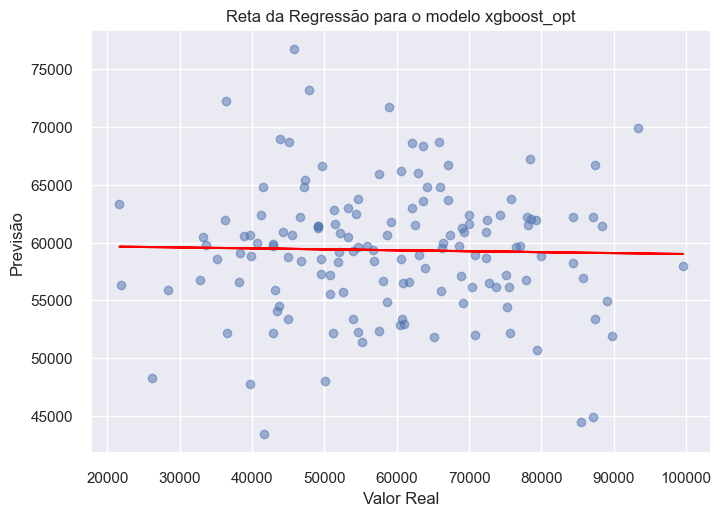

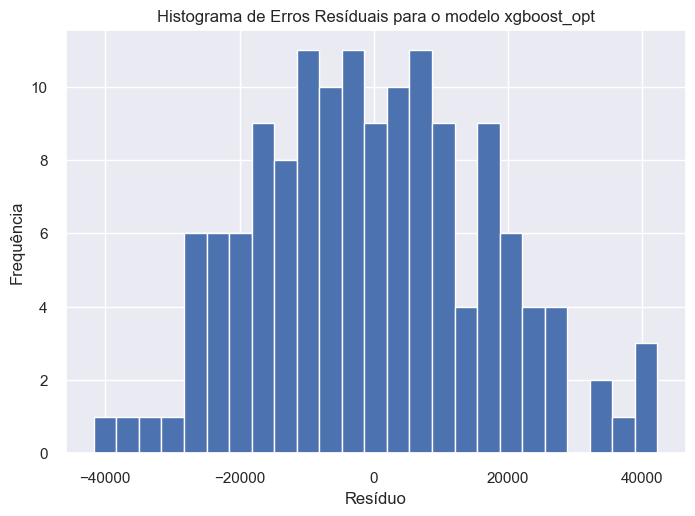

2023-04-26 15:26:24,079 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  xgboost_opt
R2 CV:   -0.07
RMSE CV: 17528.83
MAPE CV: 28.68%


2023-04-26 15:26:27,921 - Ciclo de vida dos modelos rastreado com sucesso!


In [64]:
# Retreinando modelo otimizado com novos hiperparâmetros
xgboost_opt = XGBRegressor(**{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'xgboost_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=xgboost_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### LIGHTGBM

In [65]:
# %%time
# # definir algoritmo a ser otimizado
# lgbm_opt =LGBMRegressor(objective="regression", n_jobs=-1)

# # define os hiperparâmetros a serem testados
# params = {
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.001],
#     "n_estimators": [100, 500, 1000],
#     "num_leaves": [31, 63, 127],
#     "min_child_samples": [1, 3, 5],
#     "reg_alpha": [0, 0.1, 1.0],
#     "reg_lambda": [0, 0.1, 1.0]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'lgbm_opt'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=lgbm_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:27,946 - Função train_validation_eval iniciada
2023-04-26 15:26:27,948 - Iniciando loop de validação cruzada
2023-04-26 15:26:27,952 - Treinando lgbm_opt com parâmetros padrão, fold 1
2023-04-26 15:26:28,074 - Prevendo conjunto de validação com lgbm_opt padrão, fold 1
2023-04-26 15:26:28,078 - Avaliando resultados nos dados de validação
2023-04-26 15:26:28,083 - Treinando lgbm_opt com parâmetros padrão, fold 2
2023-04-26 15:26:28,186 - Prevendo conjunto de validação com lgbm_opt padrão, fold 2
2023-04-26 15:26:28,189 - Avaliando resultados nos dados de validação
2023-04-26 15:26:28,193 - Treinando lgbm_opt com parâmetros padrão, fold 3
2023-04-26 15:26:28,301 - Prevendo conjunto de validação com lgbm_opt padrão, fold 3
2023-04-26 15:26:28,303 - Avaliando resultados nos dados de validação
2023-04-26 15:26:28,314 - Treinando lgbm_opt com parâmetros padrão, fold 4
2023-04-26 15:26:28,439 - Prevendo conjunto de validação com lgbm_opt padrão, fold 4
2023-04-26 15:26:28,450 

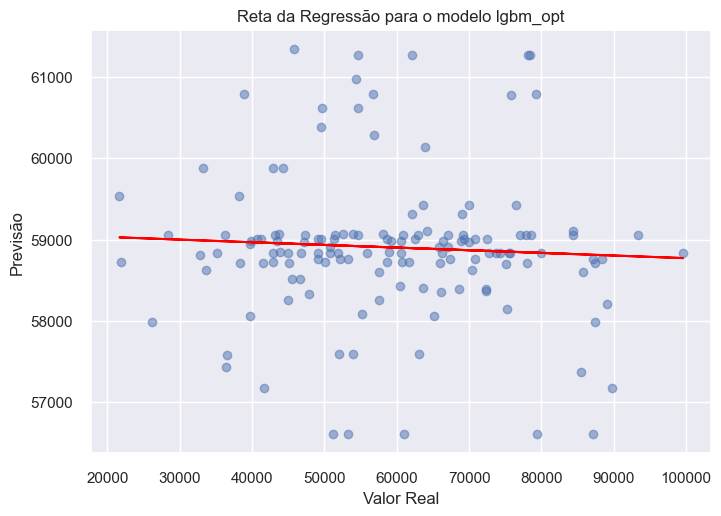

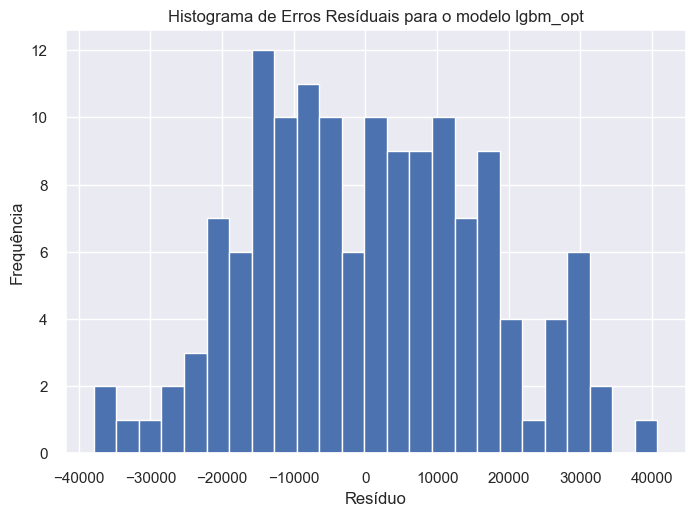

2023-04-26 15:26:29,422 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  lgbm_opt
R2 CV:   -0.00
RMSE CV: 16933.79
MAPE CV: 27.98%


2023-04-26 15:26:33,482 - Ciclo de vida dos modelos rastreado com sucesso!


In [66]:
# Retreinando modelo otimizado com novos hiperparâmetros
lgbm_opt =LGBMRegressor(**{'learning_rate': 0.001, 'max_depth': 7, 'min_child_samples': 5, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 1.0, 'reg_lambda': 0})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'lgbm_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=lgbm_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### CATBOOST

In [67]:
# %%time
# # definir algoritmo a ser otimizado
# catboost_opt = CatBoostRegressor(loss_function="RMSE", verbose=False)

# # define os hiperparâmetros a serem testados
# params = {
#     "depth": [3, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.001],
#     "iterations": [100, 500, 1000],
#     "l2_leaf_reg": [1, 3, 5],
#     "bagging_temperature": [0, 1, 10],
#     "random_strength": [0, 1, 10]
# }

# experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# # Executar função com GridSearch
# date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# model_name = 'catboost_opt'
# model_name_date = model_name + ' - ' + date
    
# train_validation_eval(model_name=model_name, model=catboost_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-26 15:26:33,520 - Função train_validation_eval iniciada
2023-04-26 15:26:33,521 - Iniciando loop de validação cruzada
2023-04-26 15:26:33,524 - Treinando catboost_opt com parâmetros padrão, fold 1
2023-04-26 15:26:33,670 - Prevendo conjunto de validação com catboost_opt padrão, fold 1
2023-04-26 15:26:33,672 - Avaliando resultados nos dados de validação
2023-04-26 15:26:33,675 - Treinando catboost_opt com parâmetros padrão, fold 2
2023-04-26 15:26:33,818 - Prevendo conjunto de validação com catboost_opt padrão, fold 2
2023-04-26 15:26:33,821 - Avaliando resultados nos dados de validação
2023-04-26 15:26:33,824 - Treinando catboost_opt com parâmetros padrão, fold 3
2023-04-26 15:26:33,965 - Prevendo conjunto de validação com catboost_opt padrão, fold 3
2023-04-26 15:26:33,968 - Avaliando resultados nos dados de validação
2023-04-26 15:26:33,972 - Treinando catboost_opt com parâmetros padrão, fold 4
2023-04-26 15:26:34,128 - Prevendo conjunto de validação com catboost_opt padrão,

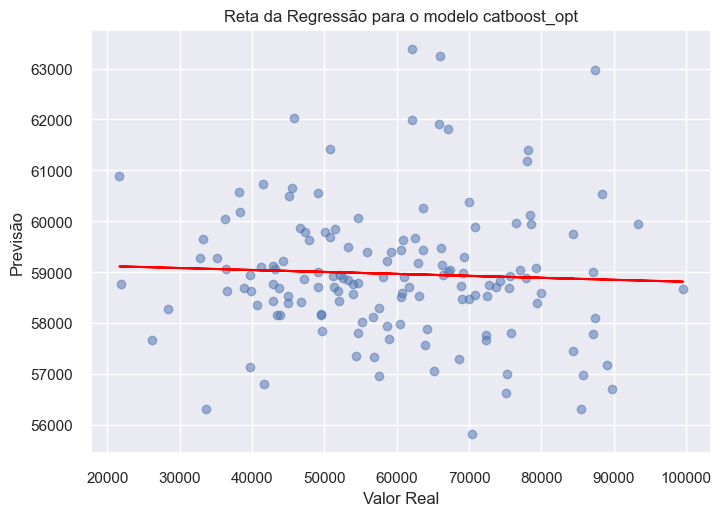

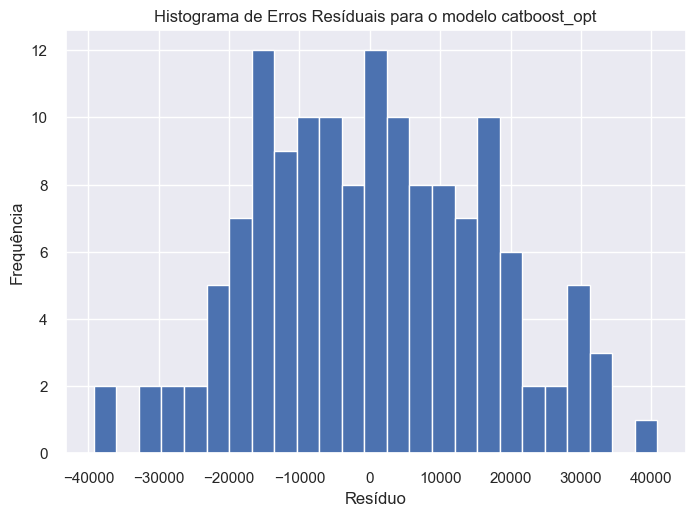

2023-04-26 15:26:35,287 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  catboost_opt
R2 CV:   -0.00
RMSE CV: 16964.24
MAPE CV: 27.96%


2023-04-26 15:26:38,988 - Ciclo de vida dos modelos rastreado com sucesso!


In [68]:
# Retreinando modelo otimizado com novos hiperparâmetros
catboost_opt = CatBoostRegressor(**{'bagging_temperature': 0, 'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_strength': 10},loss_function="RMSE", verbose=False)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'catboost_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=catboost_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

### Resultados:

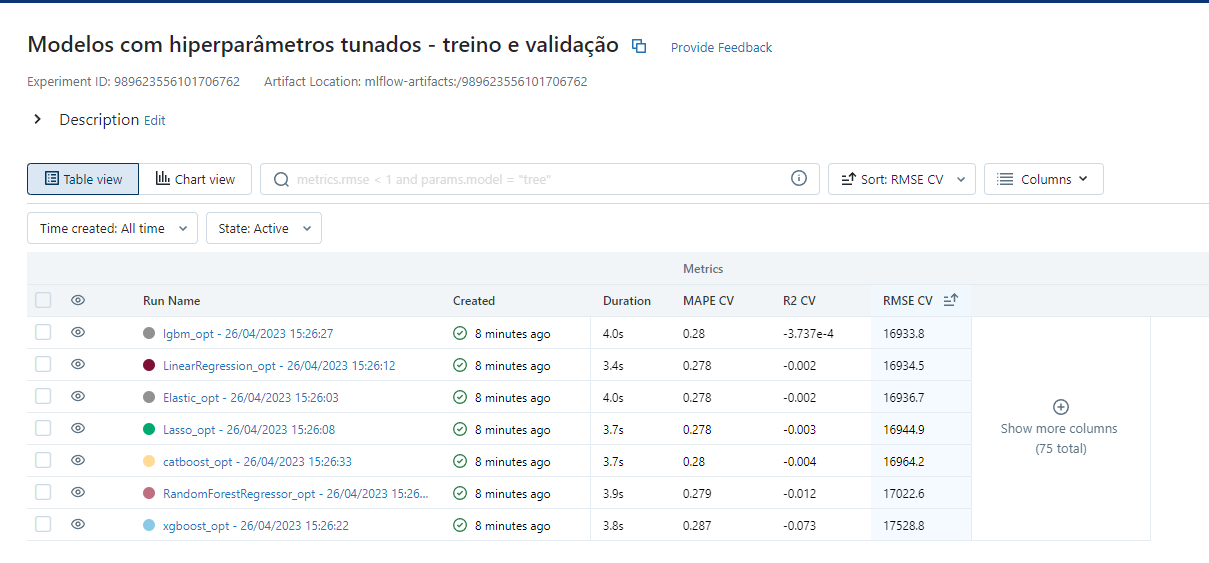

## Teste

In [69]:
# Adicionar cluster ao teste prevendo com Kmeans
logged_model = 'runs:/e8768a7f27fc4b94ae784289ce488a5e/Kmeans_12'
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

km_12_teste = loaded_model.predict(df_teste.drop(['store_id','store_sales'], axis=1))

In [70]:
# Adicionar labels ao conjunto de teste
df_teste['store_cluster'] = km_12_teste

In [71]:
# Separar variáveis independentes e dependente
X_test = df_teste.drop(['store_sales','daily_customer_count'], axis=1)
y_test = df_teste['store_sales']

In [72]:
X_test.head()

store_id  store_area  items_available  store_cluster
716       717         967             1154             10
717       718        1582             1894              6
718       719        1430             1743              2
719       720        1827             2160              5
720       721        1118             1338             11

In [73]:
y_test

716    45780
717    41800
718    53230
719    36160
720    40450
       ...  
891    66390
892    82080
893    76440
894    96610
895    54340
Name: store_sales, Length: 180, dtype: int64

In [74]:
#X_test = X_test.pipe(feature_engineering)

In [75]:
#X_test = X_test.drop(['Daily_Customer_Count','Average_frequency_of_visits','Store_Occupancy_Rate'],axis=1)
#X_test.head()

In [76]:
# definir função de avaliação para conjunto de teste
def test_eval(model_name, model, X_test, y_test, run_name=None, experiment_name=None, path_save_fig=None):
    
    logging.info("Prevendo conjunto de teste com modelo treinado")
    yhat = model.predict(X_test)
    
    logging.info("Avaliando resultados nos dados de teste")
    #Avaliação
    # R2
    R2 = r2_score(y_test, yhat)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    # MAPE
    MAPE = mean_absolute_percentage_error(y_test, yhat)
    
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_test, yhat, 1)
    plt.scatter(y_test, yhat, alpha=0.5)
    plt.plot(y_test, np.polyval(p, y_test), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_test - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
   
        
    # Avaliação na validação
    print(f"Modelo: {model_name}")
    print(f"R2:     {R2:.2f}")
    print(f"RMSE:   {RMSE:.2f}")
    print(f"MAPE:   {MAPE:.2%}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        
        mlflow.log_metric('R2', R2)
        mlflow.log_metric('RMSE', RMSE)
        mlflow.log_metric('MAPE', MAPE)
        mlflow.log_params(model.get_params())
        
        try:
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        except:
            pass
        
        for framework in [mlflow.sklearn, mlflow.xgboost, mlflow.lightgbm, mlflow.catboost]:
            try:
                framework.log_model(model, model_name)
                break
            except Exception:
                pass
            
    mlflow.end_run()
    logging.info('Ciclo de vida do modelo rastreado com sucesso!')
    return RMSE, MAPE
    

### ElasticNet otimizado

2023-04-26 15:35:52,590 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:35:52,593 - Avaliando resultados nos dados de teste


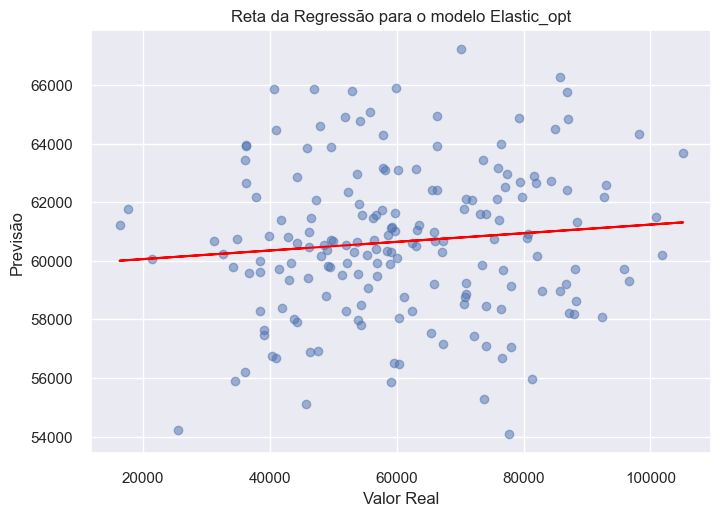

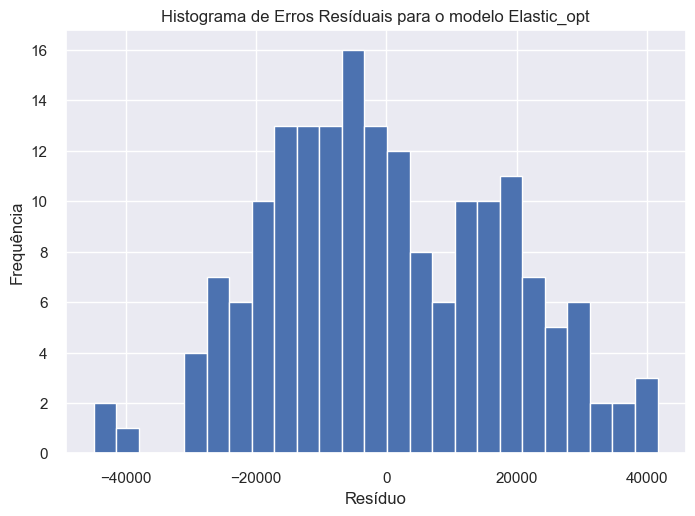

2023-04-26 15:35:53,339 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/26 15:35:53 INFO mlflow.tracking.fluent: Experiment with name 'Teste' does not exist. Creating a new experiment.


Modelo: Elastic_opt
R2:     0.01
RMSE:   17807.73
MAPE:   28.60%


2023-04-26 15:35:57,178 - Ciclo de vida do modelo rastreado com sucesso!


(17807.730109399705, 0.28596613622328104)

In [77]:
# Melhor modelo apresentado do Sklearn

experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=Elastic_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Lasso otimizado

2023-04-26 15:35:57,192 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:35:57,195 - Avaliando resultados nos dados de teste


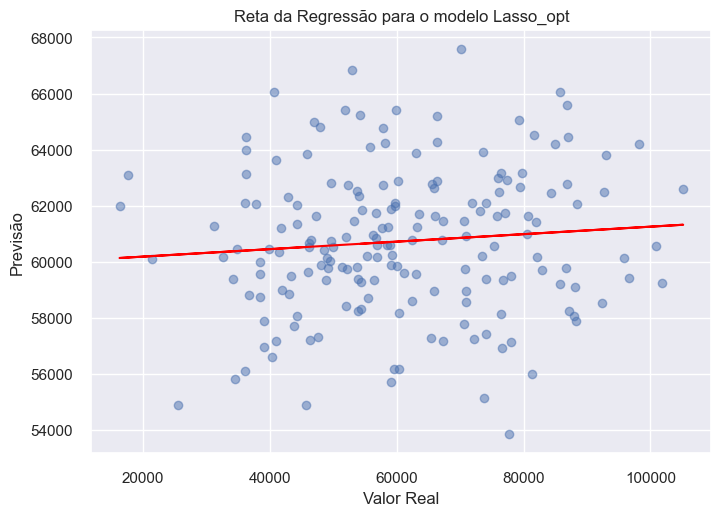

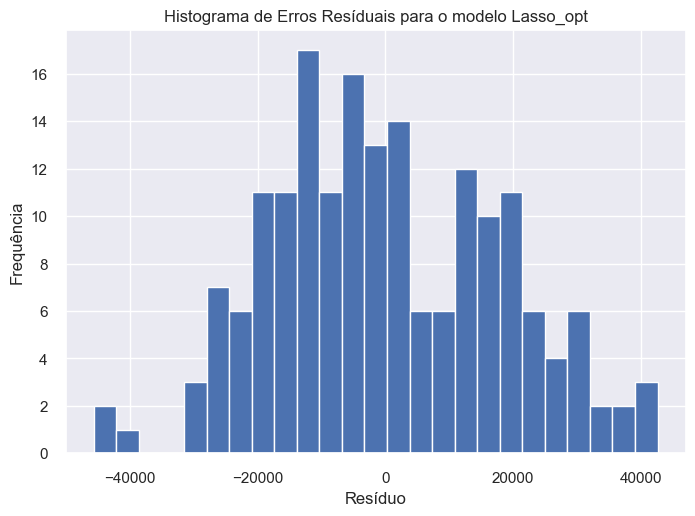

2023-04-26 15:35:57,898 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: Lasso_opt
R2:     0.01
RMSE:   17835.43
MAPE:   28.65%


2023-04-26 15:36:01,650 - Ciclo de vida do modelo rastreado com sucesso!


(17835.430434730635, 0.2865124869998378)

In [78]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=lasso_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### LinearRegression otimizado

2023-04-26 15:36:01,670 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:36:01,673 - Avaliando resultados nos dados de teste


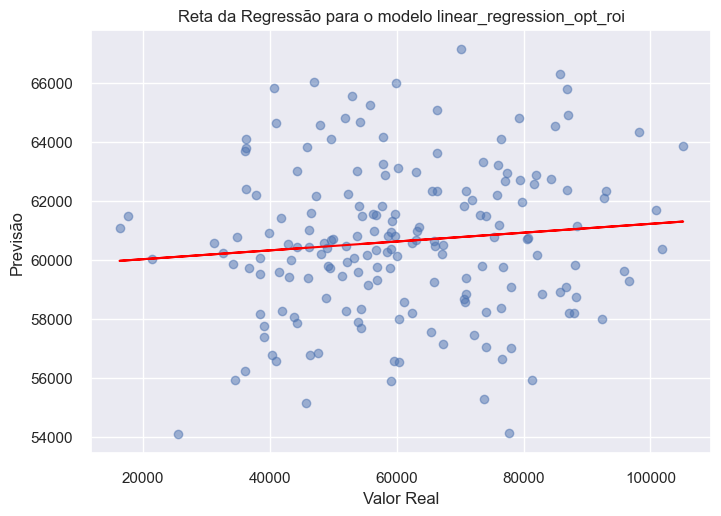

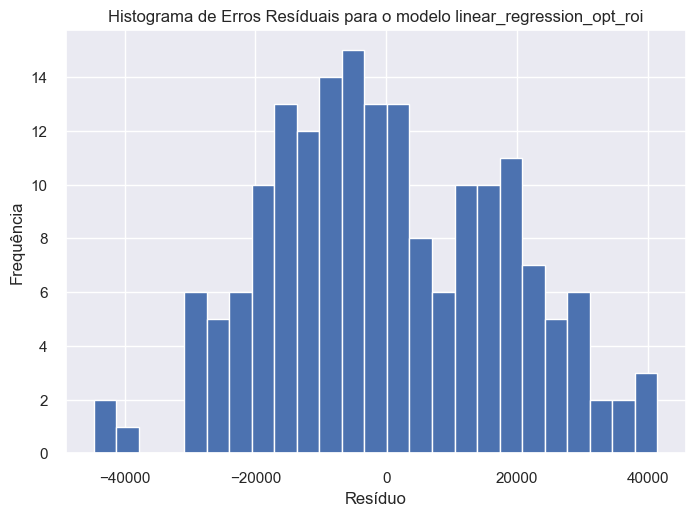

2023-04-26 15:36:02,397 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: linear_regression_opt_roi
R2:     0.01
RMSE:   17804.53
MAPE:   28.59%


2023-04-26 15:36:06,072 - Ciclo de vida do modelo rastreado com sucesso!


In [79]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'linear_regression_opt_roi'
model_name_date = model_name + ' - ' + date


RMSE_LR, MAPE_LR = test_eval(model_name=model_name, model=linear_regression_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### RandomForestRegressor otimizado

2023-04-26 15:36:06,089 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:36:06,108 - Avaliando resultados nos dados de teste


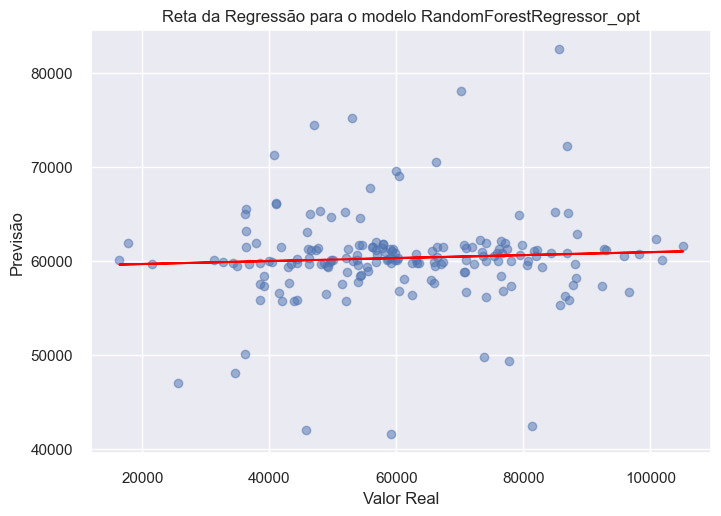

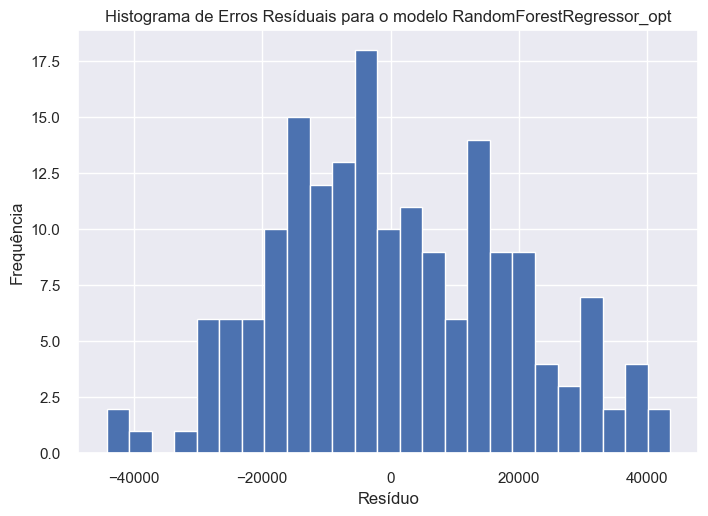

2023-04-26 15:36:06,789 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: RandomForestRegressor_opt
R2:     -0.04
RMSE:   18273.99
MAPE:   28.83%


2023-04-26 15:36:10,892 - Ciclo de vida do modelo rastreado com sucesso!


(18273.99229777388, 0.2883467418332778)

In [80]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=rfr_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### XGBOOST Otimizado

2023-04-26 15:36:10,904 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:36:10,918 - Avaliando resultados nos dados de teste


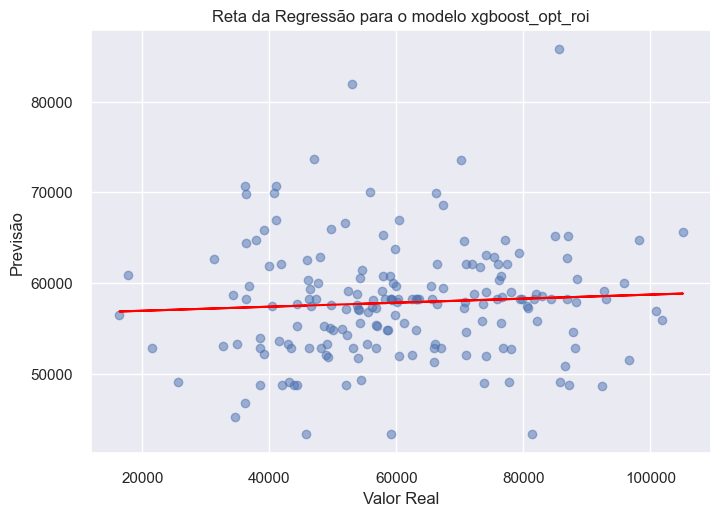

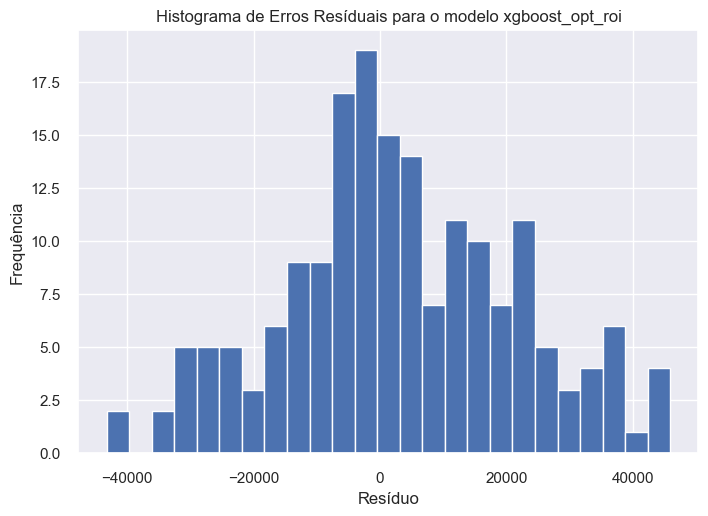

2023-04-26 15:36:11,648 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: xgboost_opt_roi
R2:     -0.11
RMSE:   18840.69
MAPE:   27.44%


2023-04-26 15:36:15,571 - Ciclo de vida do modelo rastreado com sucesso!


In [81]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'xgboost_opt_roi'
model_name_date = model_name + ' - ' + date


RMSE_XGB, MAPE_XGB = test_eval(model_name=model_name, model=xgboost_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### LIGHTGBM Otimizado

2023-04-26 15:36:15,587 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:36:15,591 - Avaliando resultados nos dados de teste


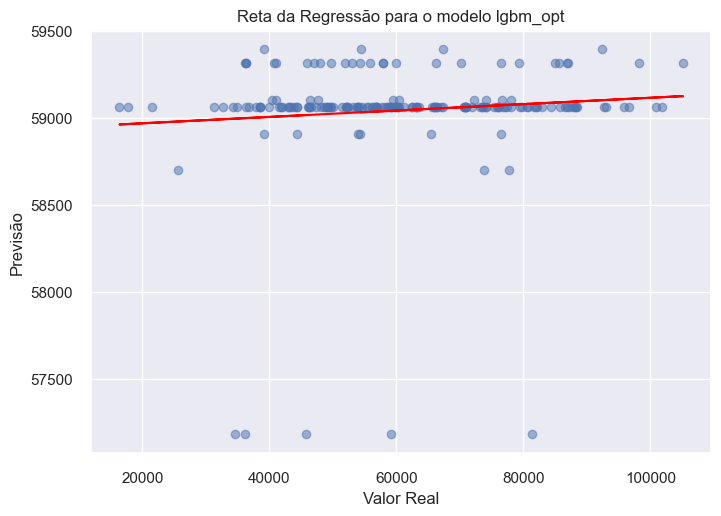

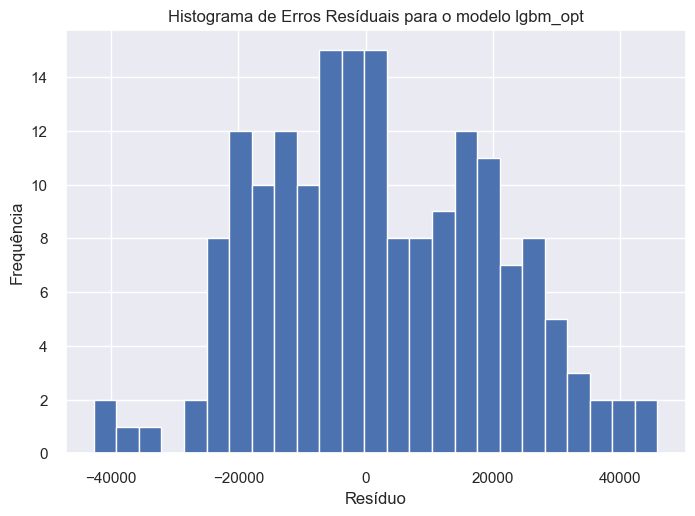

2023-04-26 15:36:16,306 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: lgbm_opt
R2:     -0.01
RMSE:   17955.33
MAPE:   27.69%


2023-04-26 15:36:20,261 - Ciclo de vida do modelo rastreado com sucesso!


(17955.334238660365, 0.2769376213245187)

In [82]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'lgbm_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=lgbm_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### CATBOOST Otimizado

2023-04-26 15:36:20,286 - Prevendo conjunto de teste com modelo treinado
2023-04-26 15:36:20,289 - Avaliando resultados nos dados de teste


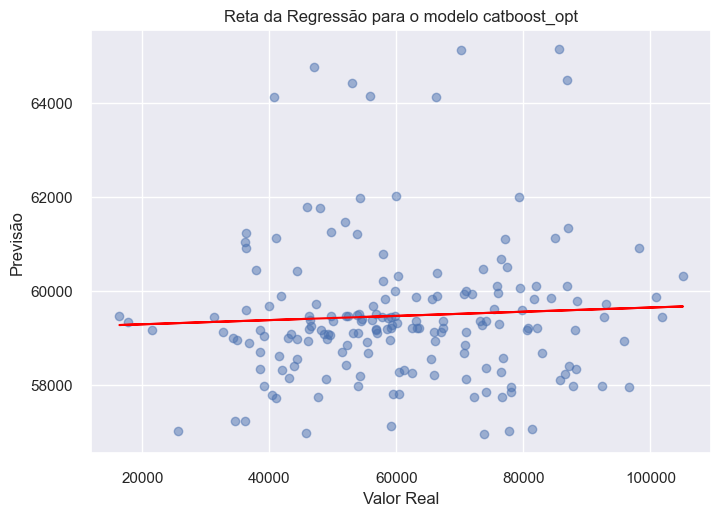

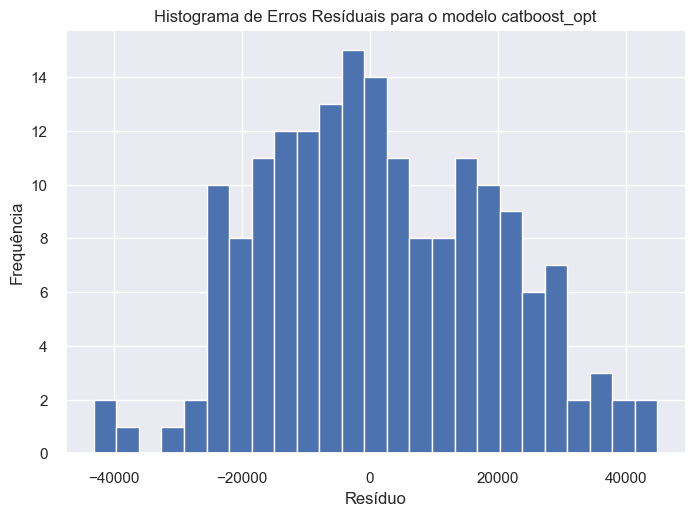

2023-04-26 15:36:20,967 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: catboost_opt
R2:     -0.00
RMSE:   17929.65
MAPE:   27.95%


2023-04-26 15:36:24,916 - Ciclo de vida do modelo rastreado com sucesso!


In [83]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'catboost_opt'
model_name_date = model_name + ' - ' + date


RMSE_CAT, MAPE_CAT = test_eval(model_name=model_name, model=catboost_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Média Móvel

In [86]:
# Definir a janela para calcular a média móvel
window_size = 5

# Calcular a média móvel para cada ponto de dados no conjunto de treino
rolling_means = []
for i in range(window_size, len(df_train)):
    # Calcular a média dos últimos N pontos de dados
    rolling_mean = np.mean(df_train['store_sales'][i-window_size:i])
    # Adicionar a média móvel à lista
    rolling_means.append(rolling_mean)

# Aplicar a média móvel no conjunto de validação (ou teste)
initial_predictions = np.full(window_size, mean_sales)
predictions_mm = np.concatenate([initial_predictions, rolling_means])

In [87]:
# Calcular erro Média Móvel
RMSE_mm = np.sqrt(mean_squared_error(df_teste['store_sales'], predictions_mm[-len(df_teste):]))
MAPE_mm = mean_absolute_percentage_error(df_teste['store_sales'], predictions_mm[-len(df_teste):])

print(f"RMSE: {RMSE_mm:.2f}")
print(f"MAPE: {MAPE_mm:.2%}")

RMSE: 18921.73
MAPE: 29.52%


### Resultados no teste

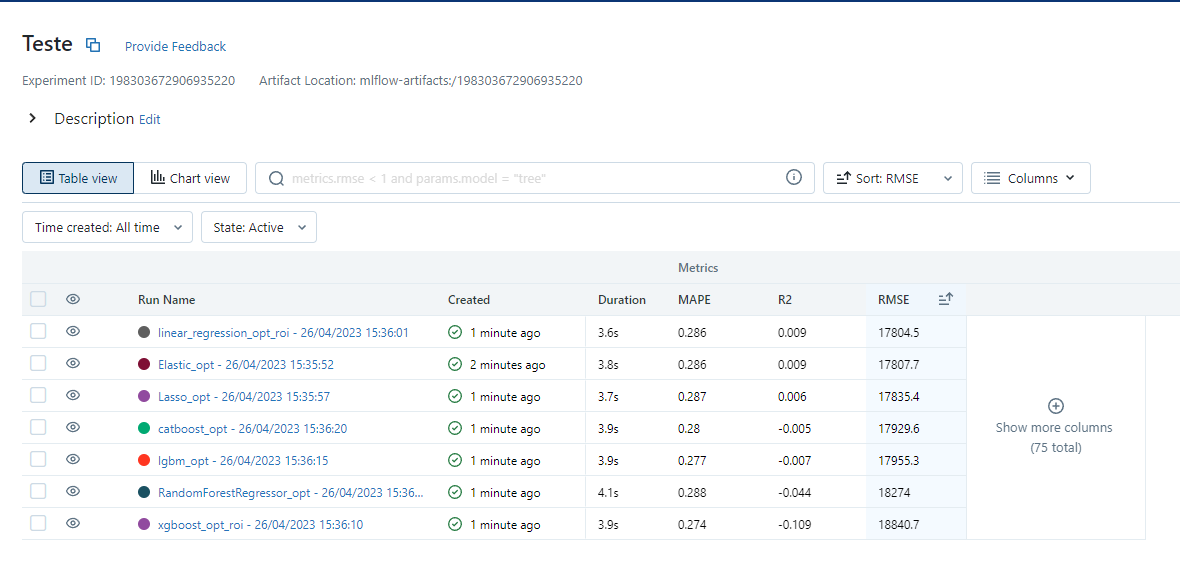

# Avaliação

In [101]:
# Modelo registrado
logged_model = 'runs:/24b4ef04c3324d479406f7ea27ffe0b1/linear_regression_opt_roi'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [89]:
# prevendo com modelo
y_pred = loaded_model.predict(X_test)

In [90]:
# adiciona previsão do modelo a base de teste original
df_teste['predict_store_sales'] = y_pred

In [91]:
# adiciona previsão de média do baseline a base de teste original
df_teste['average_store_sales'] = predictions

In [92]:
df_teste.head()

store_id  store_area  items_available  daily_customer_count  store_sales  \
716       717         967             1154                   560        45780   
717       718        1582             1894                  1100        41800   
718       719        1430             1743                   970        53230   
719       720        1827             2160                   930        36160   
720       721        1118             1338                  1040        40450   

     store_cluster  predict_store_sales  average_store_sales  
716             10         55176.671276         58961.005587  
717              6         61429.079962         58961.005587  
718              2         60079.956400         58961.005587  
719              5         63691.010826         58961.005587  
720             11         56780.573448         58961.005587

In [93]:
def mean_absolute_percentage_error(y_true, yhat):
    return np.mean(np.abs((y_true - yhat) / y_true))

def mean_absolute_error(y_true, yhat):
    return np.mean(np.abs(y_true - yhat))

def root_mean_squared_error(y_true, yhat):
    return np.sqrt(((y_true - yhat) ** 2).mean())

In [94]:
df_teste['mae_model'] = df_teste.apply(lambda x: mean_absolute_error(x['store_sales'], x['predict_store_sales']),axis=1) 
df_teste['mape_model'] = df_teste.apply(lambda x: mean_absolute_percentage_error(x['store_sales'], x['predict_store_sales']),axis=1) 
df_teste['rmse_model'] = df_teste.apply(lambda x: root_mean_squared_error(x['store_sales'], x['predict_store_sales']),axis=1) 

df_teste['best_scenario_model'] = df_teste['predict_store_sales'] + df_teste['mae_model']
df_teste['worst_scenario_model'] = df_teste['predict_store_sales'] - df_teste['mae_model']

In [95]:
df_teste.head()

store_id  store_area  items_available  daily_customer_count  store_sales  \
716       717         967             1154                   560        45780   
717       718        1582             1894                  1100        41800   
718       719        1430             1743                   970        53230   
719       720        1827             2160                   930        36160   
720       721        1118             1338                  1040        40450   

     store_cluster  predict_store_sales  average_store_sales     mae_model  \
716             10         55176.671276         58961.005587   9396.671276   
717              6         61429.079962         58961.005587  19629.079962   
718              2         60079.956400         58961.005587   6849.956400   
719              5         63691.010826         58961.005587  27531.010826   
720             11         56780.573448         58961.005587  16330.573448   

     mape_model    rmse_model  best_scenario_model  worst_scenario_model  
716    0.205257   9396.671276         64573.342552               45780.0  
717    0.469595  19629.079962         81058.159925               41800.0  
718    0.128686   6849.956400         66929.912800               53230.0  
719    0.761366  27531.010826         91222.021652               36160.0  
720    0.403722  16330.573448         73111.146895               40450.0

In [96]:
def calculate_model_revenue(df):
    """
        Calcula o retorno do investimento (ROI) de um modelo em relação ao baseline de média.

        Args:
            df : pandas.DataFrame, um dataframe contendo os dados do modelo.

        Returns:
            - "Baseline $": o retorno do baseline de média em dólares
            - "Model $": o retorno do modelo em dólares
            - "Diff Model/Baseline": a diferença entre a soma de vendas prevista pelo modelo e pelo baseline, diz o quanto o modelo acertou a mais que o baseline em termos de vendas
        """
    # Calcula o retorno do modelo em relação ao baseline de média
    baseline_return = df['average_store_sales'].sum() - df['store_sales'].sum()
    model_return = df['predict_store_sales'].sum() - df['store_sales'].sum()
    diff_model_baseline = (model_return - baseline_return)
    
    # Formata os resultados para exibição
    baseline_return_formatted = f'${baseline_return:,.2f}'
    model_return_formatted = f'${model_return:,.2f}'
    diff_model_baseline_formatted = f'${diff_model_baseline:,.2f}'

    print(f'O valor do retorno do baseline de média é de {baseline_return_formatted}')
    print(f'O valor do retorno do modelo é de {model_return_formatted}')
    print(f'A diferença entre o modelo e o baseline de média é de {diff_model_baseline_formatted}')
    
    return None

In [97]:
calculate_model_revenue(df_teste)

O valor do retorno do baseline de média é de $-349,708.99
O valor do retorno do modelo é de $-46,429.78
A diferença entre o modelo e o baseline de média é de $303,279.21


- O modelo é melhor que o baseline, ele consegue recuperar $303.279,21 que eram perdidos ao usar a média das ultimas vendas como previsão das próximas.

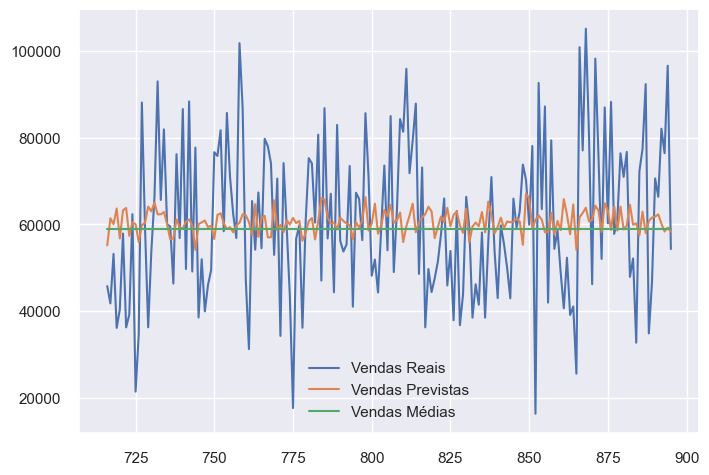

In [98]:
ax = plt.figure()
plt.plot(df_teste['store_sales'], label='Vendas Reais')
plt.plot(df_teste['predict_store_sales'], label='Vendas Previstas')
plt.plot(df_teste['average_store_sales'], label='Vendas Médias')
plt.legend()
plt.show()

# Próximo passo está no notebook (Model Serving Predict)